# Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях». <br>
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента. <br>
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

## Загрузка и подготовка данных

In [1]:

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import math
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
try: 
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')
except:
    try:
        df_train = pd.read_csv('C:\\Users\pavki\pythonCourse\jupiter tasks/datasets/hotel_train.csv')
        df_test = pd.read_csv('C:\\Users\pavki\pythonCourse\jupiter tasks/datasets/hotel_test.csv')
    except:
            df_train = pd.read_csv('C:\\datasets\hotel_train.csv')
            df_test = pd.read_csv('C:\\datasets\hotel_test.csv')

In [4]:
pd.set_option('display.max_columns', None)

Решил посмотреть, попробовать новый инструмент. 

In [5]:
#pandas_profiling.ProfileReport(df_train)

In [6]:
#pandas_profiling.ProfileReport(df_test)

In [7]:
def info(dataset):
    print(dataset.head(5))
    print(dataset.info())
    print(dataset.describe())

In [8]:
# Общая инфо для тренировочного датафрейма
info(df_train)

   id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   
3   3            0        9.0               2015               July   
4   4            1       85.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0  

In [9]:
# Общая инфо для тестового датафрейма
info(df_test)

     id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  6086            1       74.0               2017            January   
1  6087            1       62.0               2017            January   
2  6088            1       62.0               2017            January   
3  6089            1       71.0               2017            January   
4  6090            1      172.0               2017            January   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     0     2.0       0.0     0.0   
1                        2                     2     2.0

***Описание данных*** <br>
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы: <br>
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
    - Contract — договор с юридическим лицом;
    - Group — групповой заезд;
    - Transient — не связано с договором или групповым заездом;
    - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
    - SC — нет дополнительных опций;
    - BB — включён завтрак;
    - HB — включён завтрак и обед;
    - FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

--------------------------------

В будущем, целевой признак для модели будет именно столбец  **is_canceled** <br>
Остальные столбцы будут использованы как признаки. <br>
Далее, я хочу детально изучить каждый столбец, посмотреть на дубликаты, пропуски, а также посмотреть на корреляции данных.


-------

In [10]:
def dupli(dataset):
    print("Дупликатов: ",dataset.duplicated().sum())
    print(dataset.isna().sum())

In [11]:
dupli(df_train)

Дупликатов:  0
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [12]:
dupli(df_test)

Дупликатов:  0
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


На первый взгляд дупликатов и Nan значений нет, однако нужно будет смотреть на все столбцы отдельно и более детально. 

In [13]:
df_train[df_train.duplicated ()]


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [14]:
# Уникальные значения для всех столбцов 
def uniques_for_data(dataset):
    for row in dataset.columns:
        print(row)
        print(dataset[row].unique())

In [15]:
#Уникальные значения для тренировочного датафрейма
uniques_for_data(df_train)

id
[    0     1     2 ... 84094 84117 84121]
is_canceled
[0 1]
lead_time
[  7.  14.   0.   9.  85.  75.  23.  18.  68.  37.  72.  48.  77.  99.
  40.  15.  36.  70.  45.  16. 107.  47.  96. 113.  50.   3.   1.  10.
   5.  17.  93.  71.  63.  62. 101.   2.  81.  12. 109. 102.   4.  92.
  95.  86.  78.  29.  30.  51.  33.   8. 100.  80.  97.  64.  90.  27.
  82.  94. 115. 111.  98.  66. 104.  65.  55.  21.  88.  43.  54. 280.
  24. 103. 249.  13.  79.  35.  31.  34.  44. 304. 117.  84. 110.  59.
 116.  91.  42.  60. 321.  32.  56.  41.  76.  49.  73. 112.  39.  58.
  57.  19.  53.  38.   6. 108.  26. 123.  28. 118.  46.  69.  52.  89.
  61.  22.  67. 105.  25.  11.  87. 299.  74. 298. 119.  20.  83. 136.
 129. 124. 130. 131. 139. 122. 106. 137. 120. 135. 150. 143. 151. 126.
 147. 128. 156. 132. 164. 159. 161. 333. 149. 154. 297. 163. 314. 323.
 340. 142. 302. 175. 166. 114. 140. 157. 310. 172. 145. 121. 127. 178.
 152. 158. 125. 185. 177. 165. 200. 192. 174. 134. 350. 283. 160. 133.
 148

In [16]:
#Уникальные значения для тренировочного датафрейма
uniques_for_data(df_test)

id
[ 6086  6087  6088 ... 97901 97902 97903]
is_canceled
[1 0]
lead_time
[ 74.  62.  71. 172.  52. 143.  21.  89.  48.  31.  20. 173.  23.  46.
 149.  44.  68.   6.  43. 112.  59.  93.   4. 115. 187.  11.   2.  15.
  66. 113. 125. 161. 154.   1.   0.  35.  37.  60. 129.  78.  10.  82.
   8.  22.  33. 108.  87. 106.  45.  40.  17.   5.  16.   3.  41. 135.
 123. 128.  47.  12. 124. 160.  58.  65. 281.  24.  30.  27.   9.  94.
 219.  84.  79.  72.  36. 292. 186.  85. 169. 166.  28.  83. 111.  54.
 200.  80. 102.  95. 170. 307. 298.  55.  77.  32.  25. 238.   7.  19.
 211. 137.  39.  18. 206.  42. 179. 205. 142.  38.  92.  56.  29. 119.
  73. 320.  34. 127.  69.  13. 140.  14. 164.  51.  70. 120.  76. 105.
  50. 191.  26.  75. 116. 184.  53.  49.  63. 194. 167. 312. 171. 218.
  86. 100. 146.  64. 148.  81.  88.  57. 339. 332. 133. 208.  61. 177.
 157. 278. 285. 210. 232. 139. 134. 204. 201. 216. 340. 350. 214. 226.
 273. 103. 136. 176. 180. 192. 175. 145. 162. 174. 117. 255. 364. 121.
 240

------

Сразу обратим внимание, что в столбцах "meal" и "reserved_room_type" куча проблемов, их не забудем отредактировать. <br>
Слегка странно, что кол-во младенцев от 0 до 2. а далее сразу есть случаи 9 и 10 младенцев. Тоже не забудем проверить. <br>
Еще интересны случаи, когда кол-во взрослых 0, возможно, что в этом и нет ошибок, но проверить стоит. 

-----------

In [17]:
#Удалили лишние пробелы
df_train['meal'] = df_train['meal'].str.strip()
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_test['meal'] = df_test['meal'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()

In [18]:
df_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [19]:
df_train.query('babies > 3')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


Что же насчет младенцев? Более вероятно, что такое действительно было и здесь нет никаких ошибок. Все очень похоже на правду, снимаем подозрения. <br>

In [20]:
df_train['babies'].unique()

array([ 0.,  1.,  2., 10.,  9.])

In [21]:
df_train.query('babies > 1')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7390,9778,0,174.0,2015,September,36,2,1,4,2.0,0.0,2.0,HB,PRT,Direct,0,0,0,C,1,0,Transient,1,2,5
15516,18273,0,47.0,2016,November,45,5,2,2,2.0,0.0,2.0,HB,GBR,TA/TO,0,0,0,A,1,0,Transient,0,5,4
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3
56050,74658,0,4.0,2016,July,31,27,0,4,2.0,0.0,2.0,BB,DNK,TA/TO,0,0,0,D,2,0,Transient,0,2,4


In [22]:
df_train.loc[df_train['babies']  > 1 , 'babies'] = 1

In [23]:
df_test.loc[df_test['babies'] > 1 , 'babies'] = 1

In [24]:
df_test['babies'].unique()

array([0., 1.])

In [25]:
df_train.query('adults == 0 ')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,August,33,10,1,1,0.0,3.0,0.0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104.0,2015,August,33,11,0,3,0.0,2.0,0.0,BB,FRA,TA/TO,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3.0,2015,August,34,16,2,0,0.0,2.0,0.0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48.0,2015,October,43,19,1,3,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6.0,2015,December,51,13,1,0,0.0,3.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,83478,0,197.0,2016,December,52,21,1,4,0.0,3.0,0.0,HB,FRA,TA/TO,0,0,0,A,7,0,Transient-Party,0,0,5
64882,83610,0,104.0,2016,December,53,25,2,1,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,1,0,Transient,0,2,3
64892,83620,0,104.0,2016,December,53,25,2,1,0.0,2.0,0.0,BB,FRA,TA/TO,0,0,0,B,0,0,Transient,0,2,3
64903,83633,0,247.0,2016,December,52,24,2,3,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,5


In [26]:
df_test.query('adults == 0 ')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7743,44932,1,111.0,2017,January,1,2,1,3,0.0,2.0,0.0,BB,RUS,TA/TO,0,0,0,B,0,0,Transient,0,2,4
7751,44940,1,268.0,2017,January,1,2,1,4,0.0,2.0,0.0,BB,RUS,TA/TO,0,0,0,B,0,0,Transient,0,1,5
8772,45961,1,148.0,2017,February,6,5,2,5,0.0,2.0,0.0,BB,FRA,TA/TO,0,0,0,B,0,0,Transient,0,2,7
9243,46432,1,134.0,2017,February,8,22,2,4,0.0,2.0,0.0,BB,BRA,TA/TO,0,0,0,B,0,0,Transient,0,1,6
9305,46494,1,148.0,2017,February,8,24,2,2,0.0,2.0,0.0,BB,BRA,TA/TO,0,0,0,B,1,0,Transient,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30601,96093,0,296.0,2017,July,30,27,1,3,0.0,2.0,0.0,BB,GBR,TA/TO,0,0,0,B,0,0,Transient,0,1,4
30654,96146,0,276.0,2017,July,31,30,2,1,0.0,2.0,0.0,BB,DEU,TA/TO,0,0,0,B,1,0,Transient,0,2,3
30678,96170,0,291.0,2017,July,30,29,2,2,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,4
30815,96307,0,159.0,2017,July,31,31,1,3,0.0,2.0,0.0,SC,FRA,TA/TO,0,0,0,A,1,0,Transient,0,1,4


Окей, без взрослых поехали детишки, однако смущает кое-что. 

In [27]:
df_train.query('adults == 0 & children == 0') 

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,31710,0,48.0,2016,February,9,21,2,4,0.0,0.0,0.0,SC,CHE,Direct,0,0,0,B,2,0,Transient-Party,0,0,6
26878,34818,0,122.0,2016,May,19,5,2,4,0.0,0.0,0.0,SC,PRT,TA/TO,0,0,0,E,3,0,Transient,0,0,6
26879,34819,0,122.0,2016,May,19,5,2,4,0.0,0.0,0.0,SC,CHE,TA/TO,0,0,0,E,3,0,Transient,0,0,6
31570,39510,0,256.0,2016,August,35,21,3,5,0.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,0,8
41461,59858,0,0.0,2015,November,49,30,1,2,0.0,0.0,0.0,SC,PRT,Corporate,1,0,1,A,2,0,Transient,0,0,3
50744,69262,0,52.0,2016,April,18,30,2,4,0.0,0.0,0.0,SC,SWE,Direct,0,0,0,E,2,0,Transient-Party,0,1,6
54881,73467,0,108.0,2016,July,28,5,2,5,0.0,0.0,0.0,SC,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,7
56674,75308,0,4.0,2016,August,32,5,2,2,0.0,0.0,0.0,SC,RUS,TA/TO,0,0,0,A,2,0,Transient,0,2,4
57390,76028,0,88.0,2016,August,34,16,0,4,0.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,5,0,Transient,0,2,4
58416,77078,0,36.0,2016,August,35,27,3,6,0.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,2,0,Transient,0,2,9


In [28]:
df_test.query('adults == 0 & children == 0') 

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18333,73610,0,55.0,2017,March,10,5,2,0,0.0,0.0,0.0,SC,PRT,Corporate,1,1,9,A,2,0,Transient,1,0,2
21214,86706,0,50.0,2017,March,9,1,0,3,0.0,0.0,0.0,BB,IRN,TA/TO,0,0,0,A,1,0,Transient,0,1,3
25596,91088,0,33.0,2017,May,19,9,0,1,0.0,0.0,0.0,SC,PRT,TA/TO,0,0,0,E,3,0,Transient,0,0,1
28463,93955,0,26.0,2017,June,25,19,1,4,0.0,0.0,0.0,SC,GBR,TA/TO,0,0,0,D,2,0,Transient,0,1,5
28821,94313,0,107.0,2017,June,26,27,0,3,0.0,0.0,0.0,BB,CHE,TA/TO,0,0,0,A,1,0,Transient,0,0,3
29808,95300,0,44.0,2017,July,28,15,1,1,0.0,0.0,0.0,SC,SWE,TA/TO,0,0,0,A,2,0,Transient,0,0,2
30052,95544,0,2.0,2017,July,28,15,2,5,0.0,0.0,0.0,SC,RUS,TA/TO,0,0,0,A,1,0,Transient-Party,0,1,7


Да, именно такой момент и смущает. Взрослых и детей по нулям, кто же тогда ездил? Очевидно, что это ошибка, но чья ошибка? Вероятнее всего, при заполнении данных о размещении клиент случайно указал везде нули, но почему же сайт отеля принял такой вариант и успешно зарегистрировал? Нужно будет обязательно им передать чтоб поставили строчку с кол-вом постояльцев под звездочкой (обязательной для заполнения)

In [29]:
df_train.loc[(df_train['adults'] == 0) & (df_train['children'] == 0), 'adults'] = 1

In [30]:
df_test.loc[(df_test['adults'] == 0) & (df_test['children'] == 0), 'adults'] = 1

In [31]:
#df_train.query('adults == 0 & children == 0')

Все же, эти данные адекватные, их немного, поэтому нулевое значение исправили на единицу. 

In [32]:
df_train.loc[df_train['children'] == 0, 'adults'] = 1

In [33]:
df_test.loc[df_test['children'] == 0, 'adults'] = 1

In [34]:
df_test.query('adults == 0 & children == 0') 

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


## Предообработка

Удалим столбец 'id', лишний столбец, для нас роли не играет, а для модели - тем более

In [35]:
df_train = df_train.drop(['id'], axis= 1)

In [36]:
df_test = df_test.drop(['id'], axis= 1)

In [37]:
#df_test.head()

In [38]:
colors = ['red', 'aquamarine']
explode = (0.05, 0.05)
def graphs_is_canceled(dataset):
    ax1 = dataset['is_canceled'].value_counts().plot.pie(autopct='%1.0f%%', colors=colors, explode=explode)
    ax1.set_title('Распределение отказов бронирования')
    plt.show()

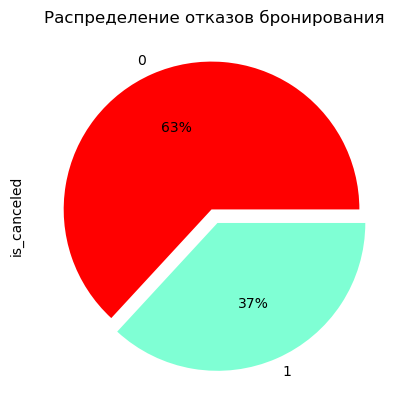

In [39]:
# Распределение отказов для датафрейма df_train
graphs_is_canceled(df_train)

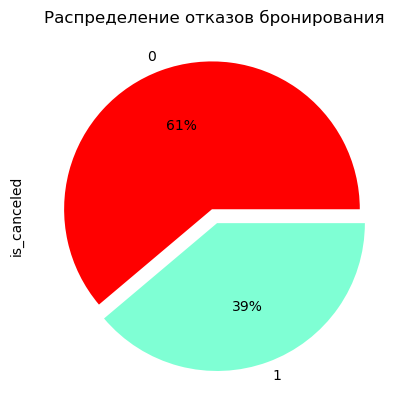

In [40]:
# Распределение отказов для датафрейма df_test
graphs_is_canceled(df_test)

Для обоих датафреймов ситуация с отказами бронирования выглядит приимерно одинаково и составляет 37 и 39 процентов для df_train и df_test соответственно.<br>
Для ситуации в целом 37-39% отмен бронирований это очень большой показатель. <br>
Но с точки зрения целевого показателя для модели - небольшой дисбаланс. 

In [41]:
datas = [df_train, df_test]
colors = sns.color_palette("Paired")
sns.set(rc={'figure.figsize':(20, 8)}, palette=colors)

In [42]:
def graphs(dataset1, dataset2):
    for column in dataset1.columns:
        if (dataset1[column].dtype != 'object') & (dataset2[column].dtype != 'object') & (column != 'is_canceled') :
            fig, ax = plt.subplots(1, 2)
            sns.distplot(dataset1[column], ax=ax[0], hist=True, kde=True, 
                color = 'blue',
                    hist_kws={ 'edgecolor':'black'},
                    kde_kws={'linewidth': 5})
            plt.ylabel('Плотность')
            ax[0].set_title('Распределение столбца \'{}\' для датасета - \'df_train\''.format(column))
            
            
            sns.distplot(dataset2[column], ax=ax[1], hist=True, kde=True, 
                color = 'green',
                    hist_kws={ 'edgecolor':'black'},
                    kde_kws={ 'linewidth': 5})
            plt.ylabel('Плотность')
            ax[1].set_title('Распределение столбца \'{}\' для датасета - \'df_test\''.format(column))
            plt.show()
            

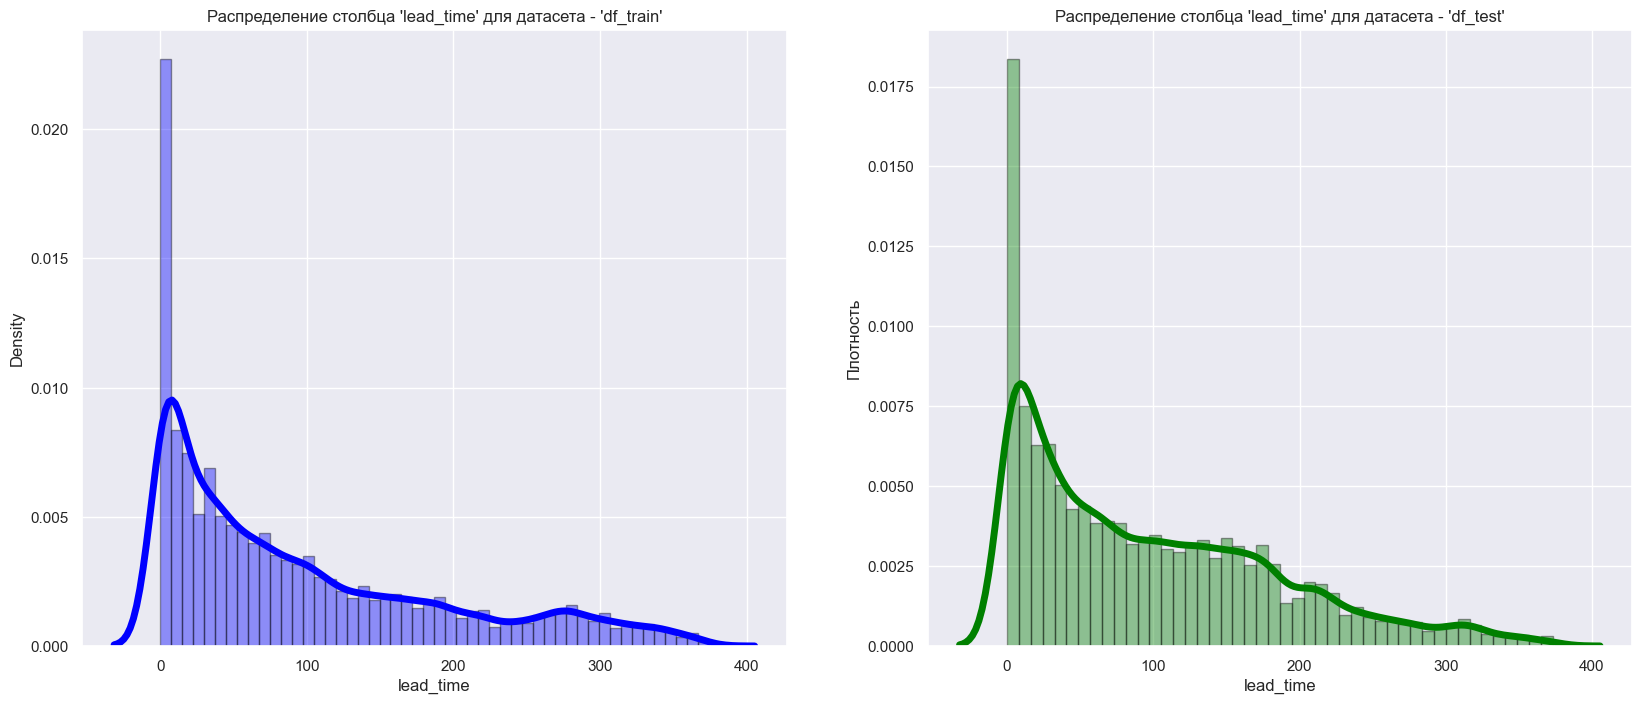

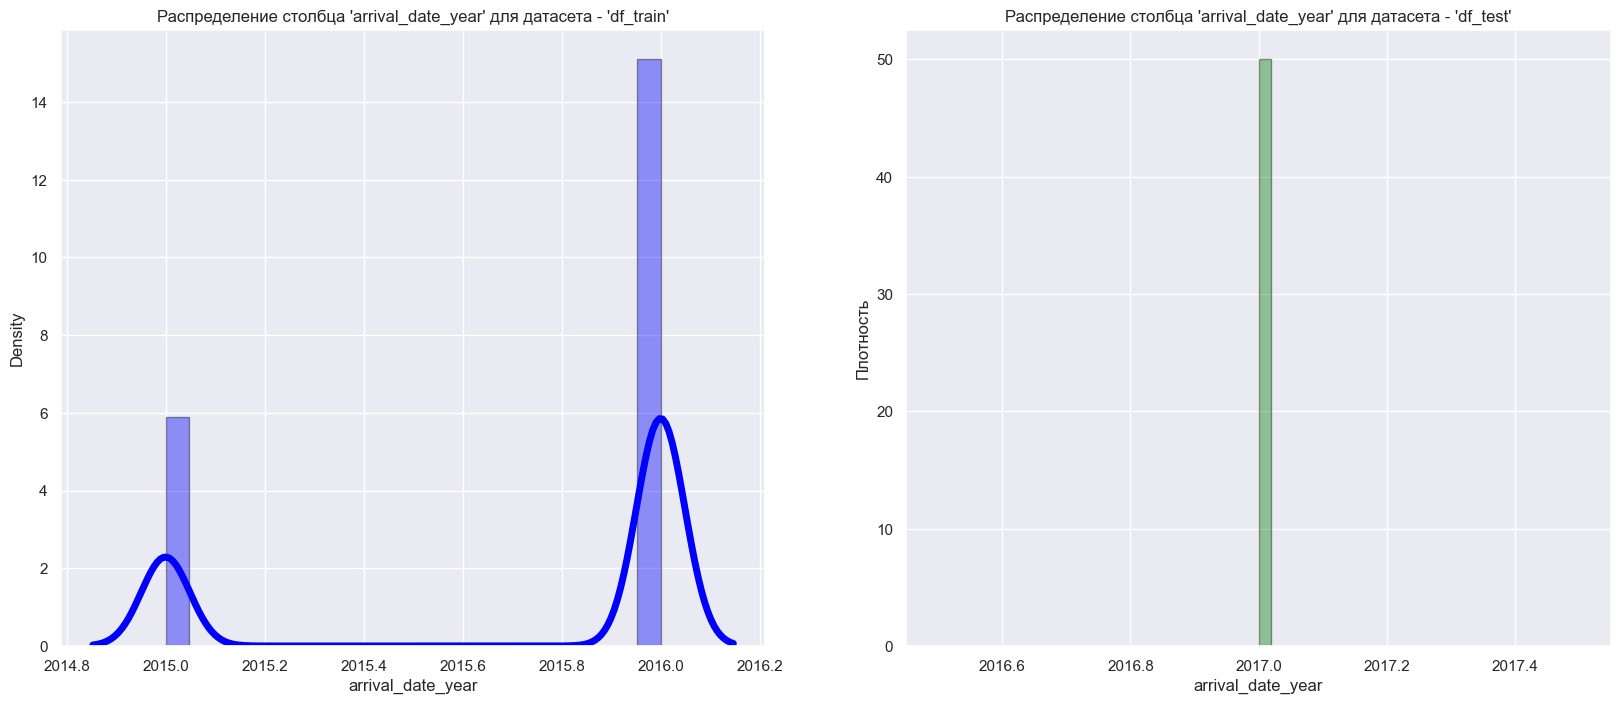

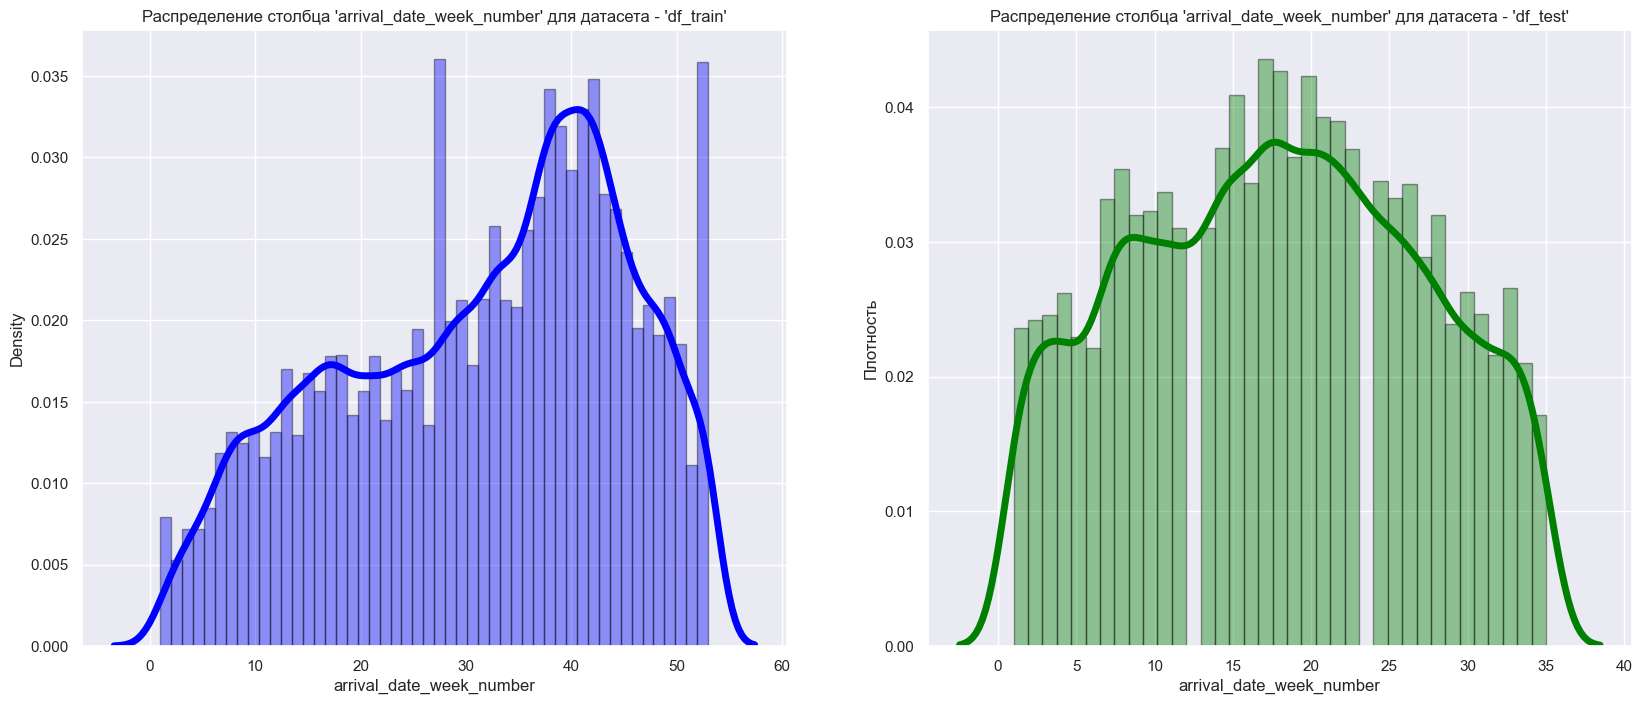

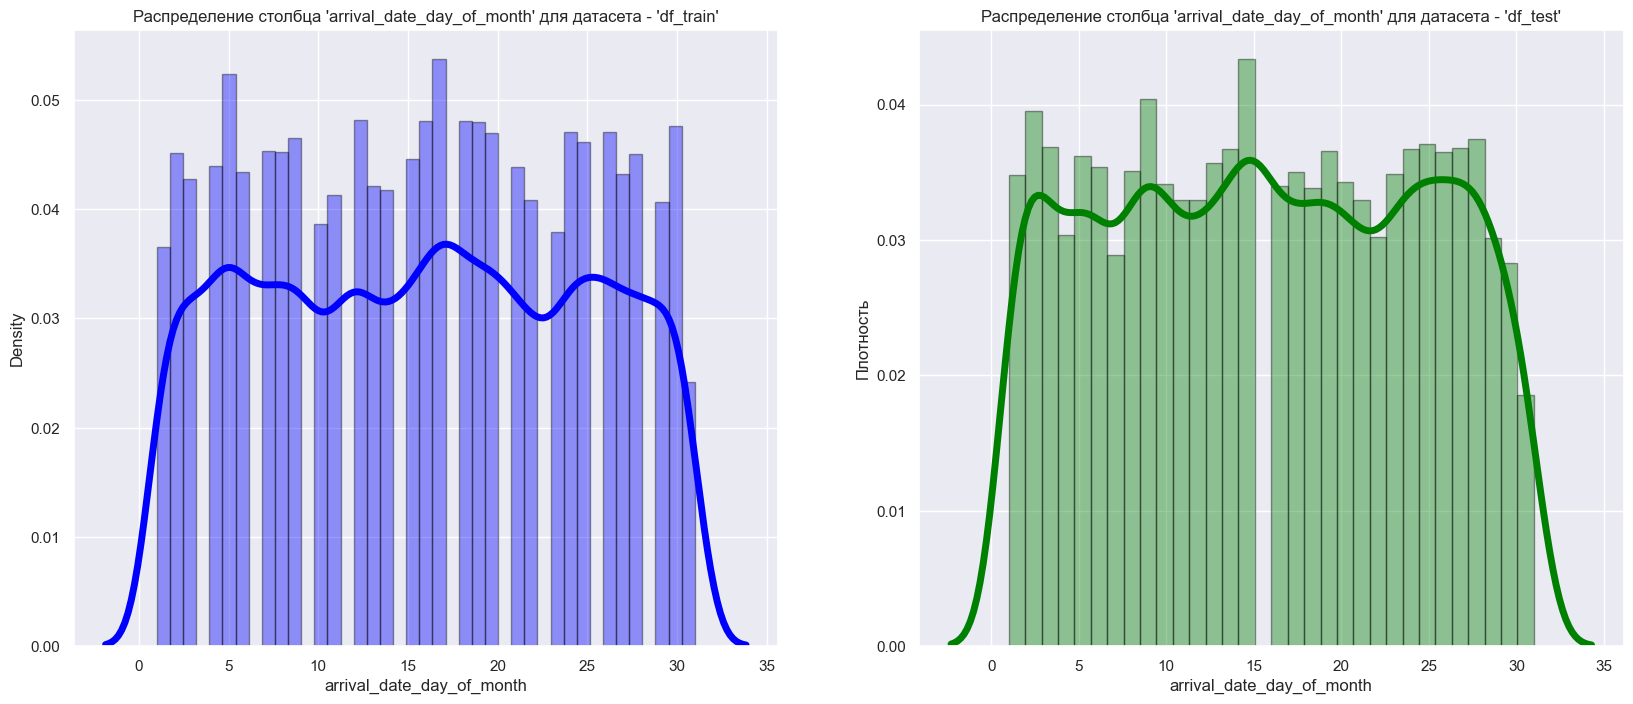

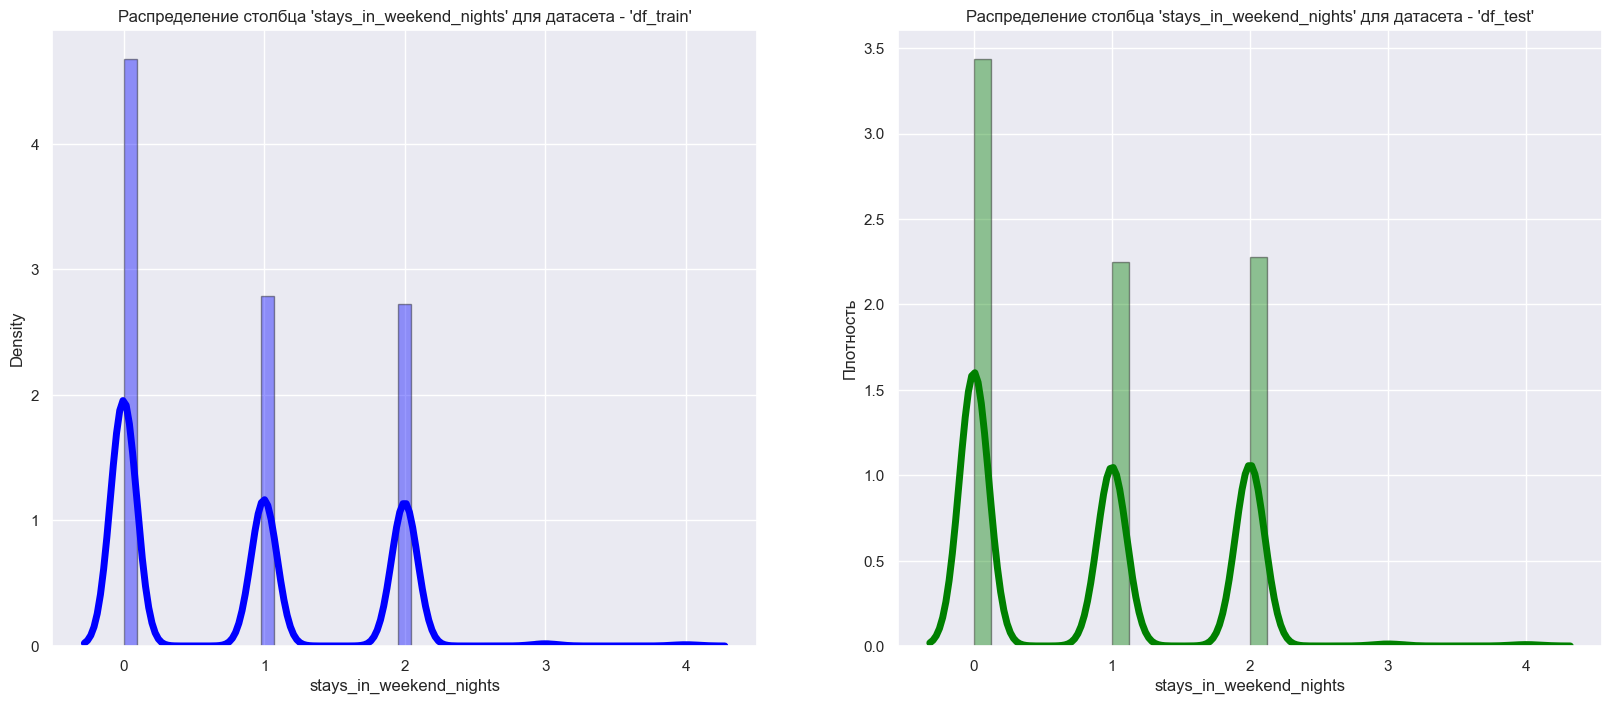

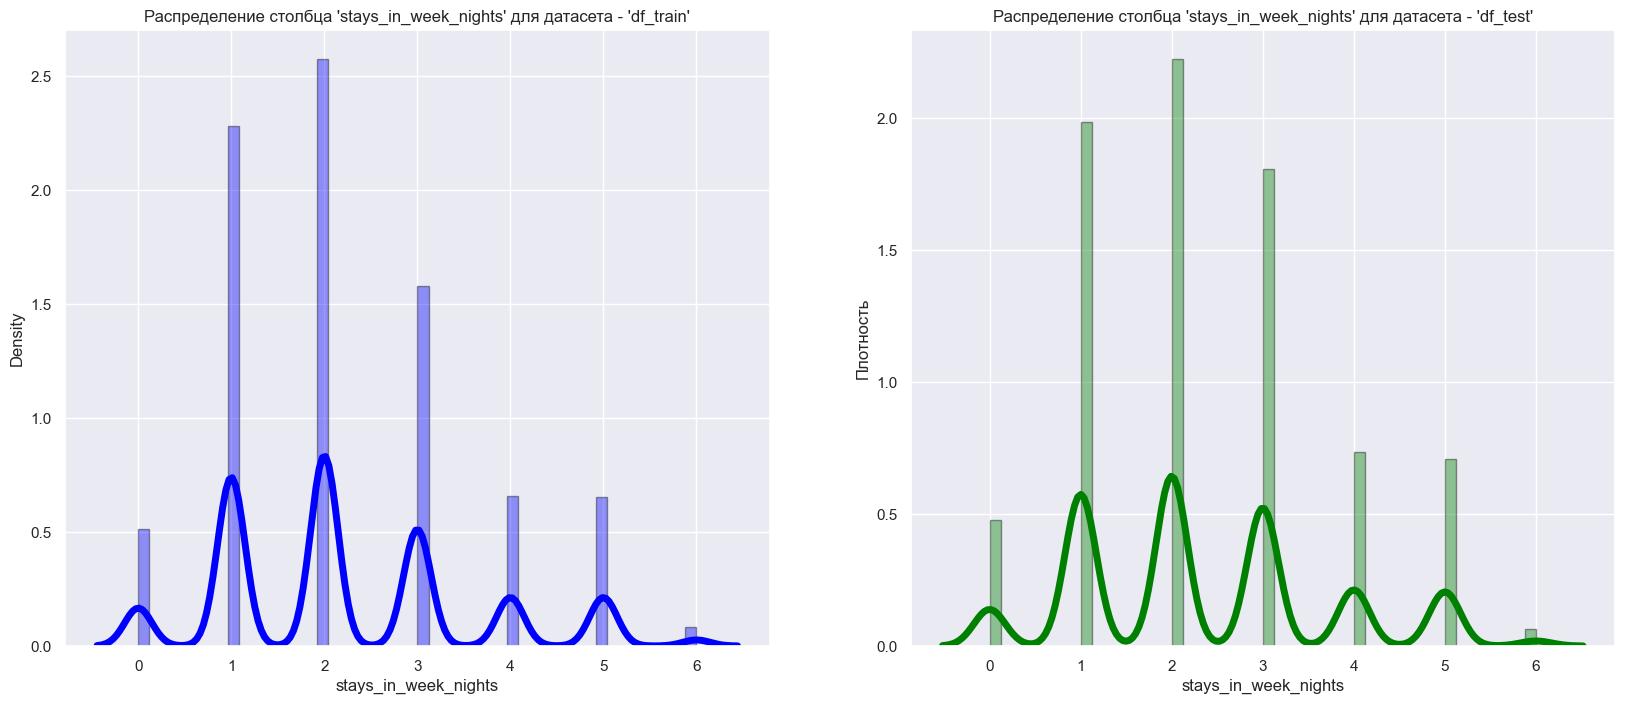

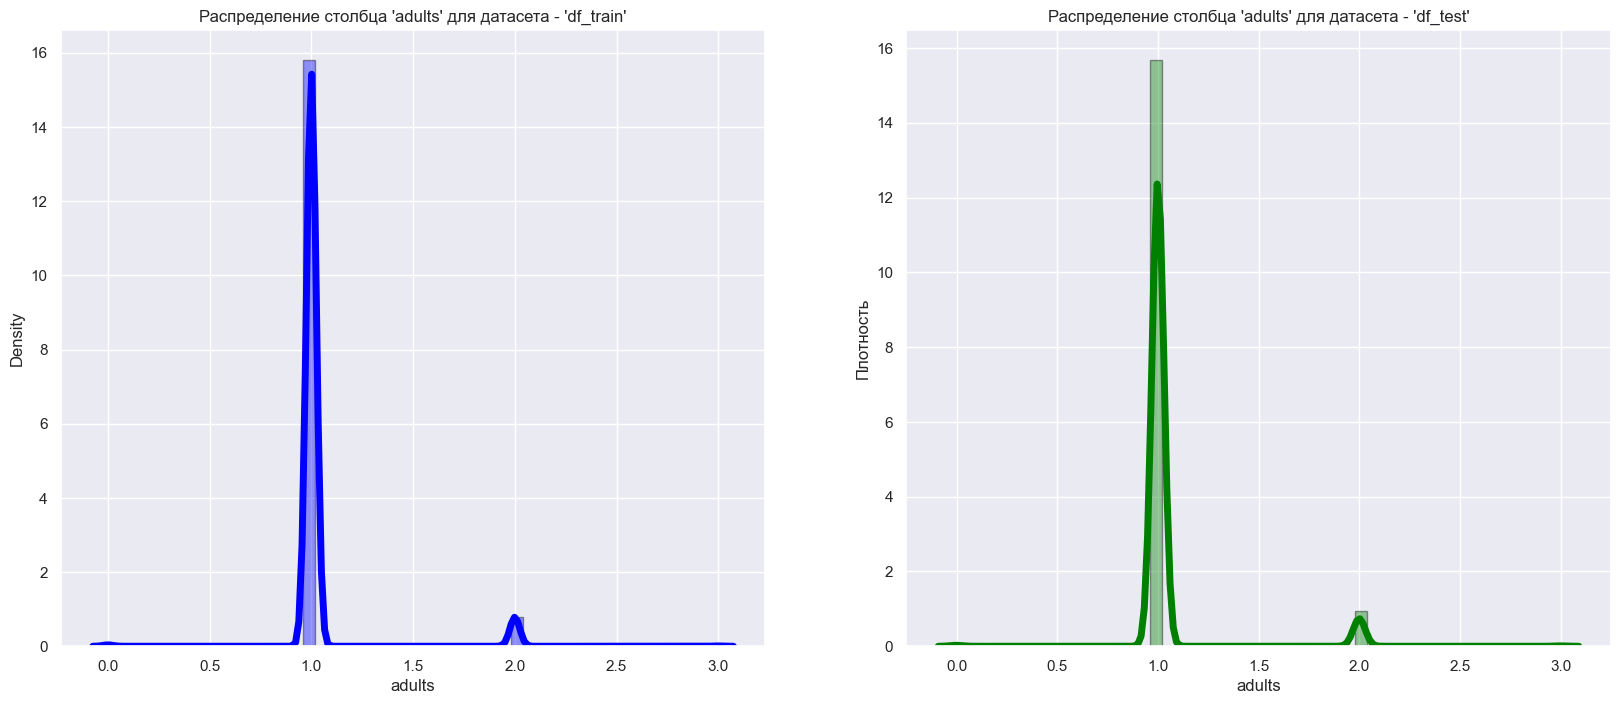

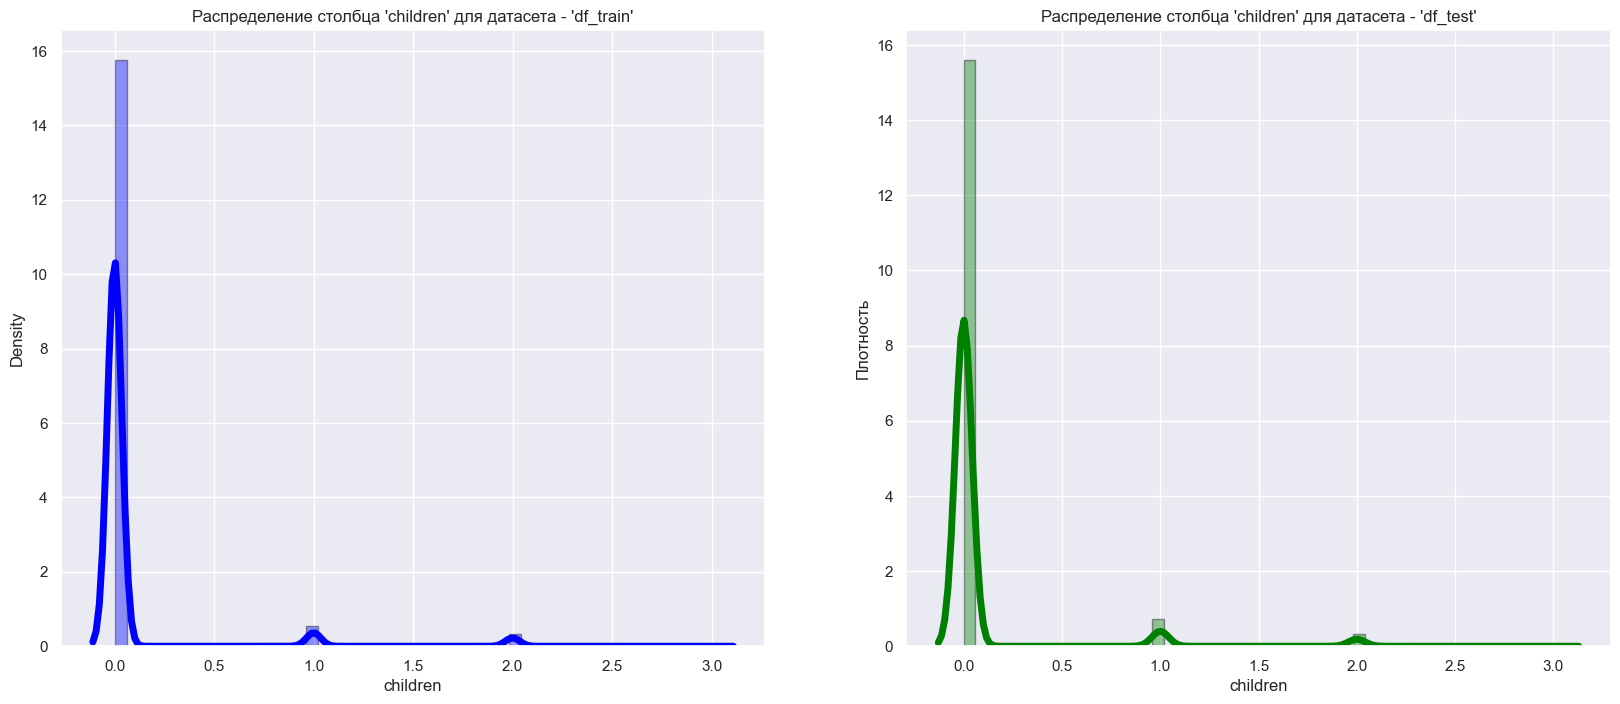

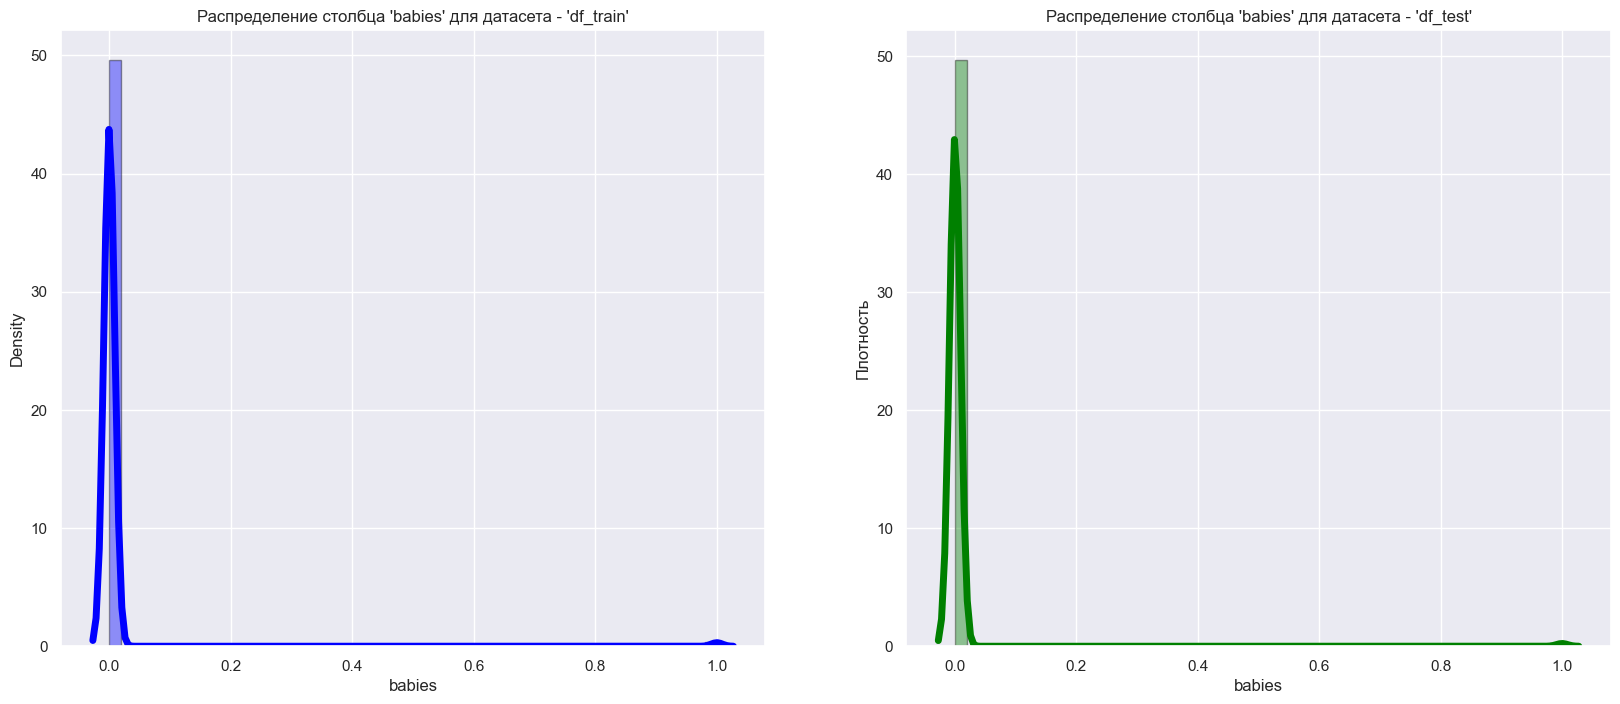

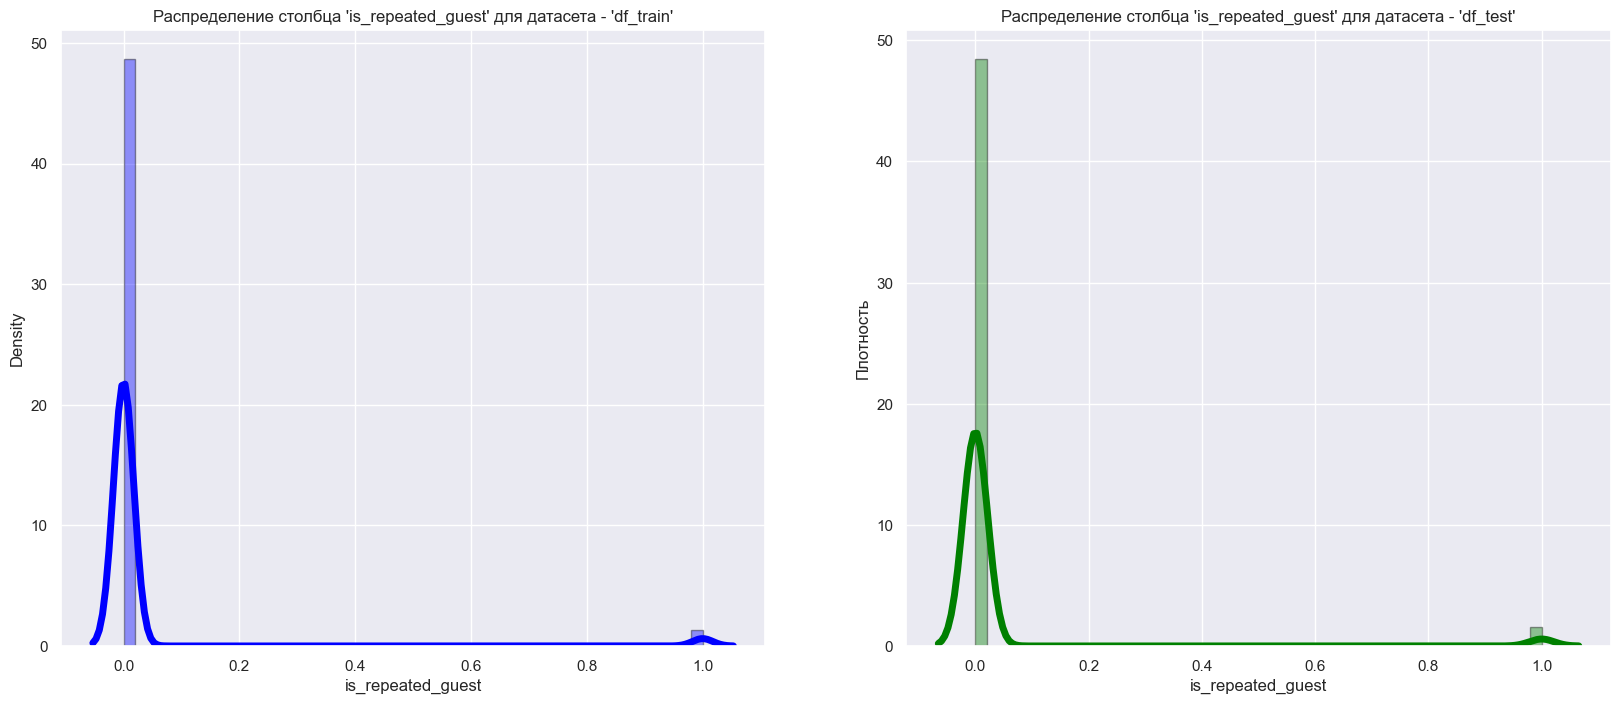

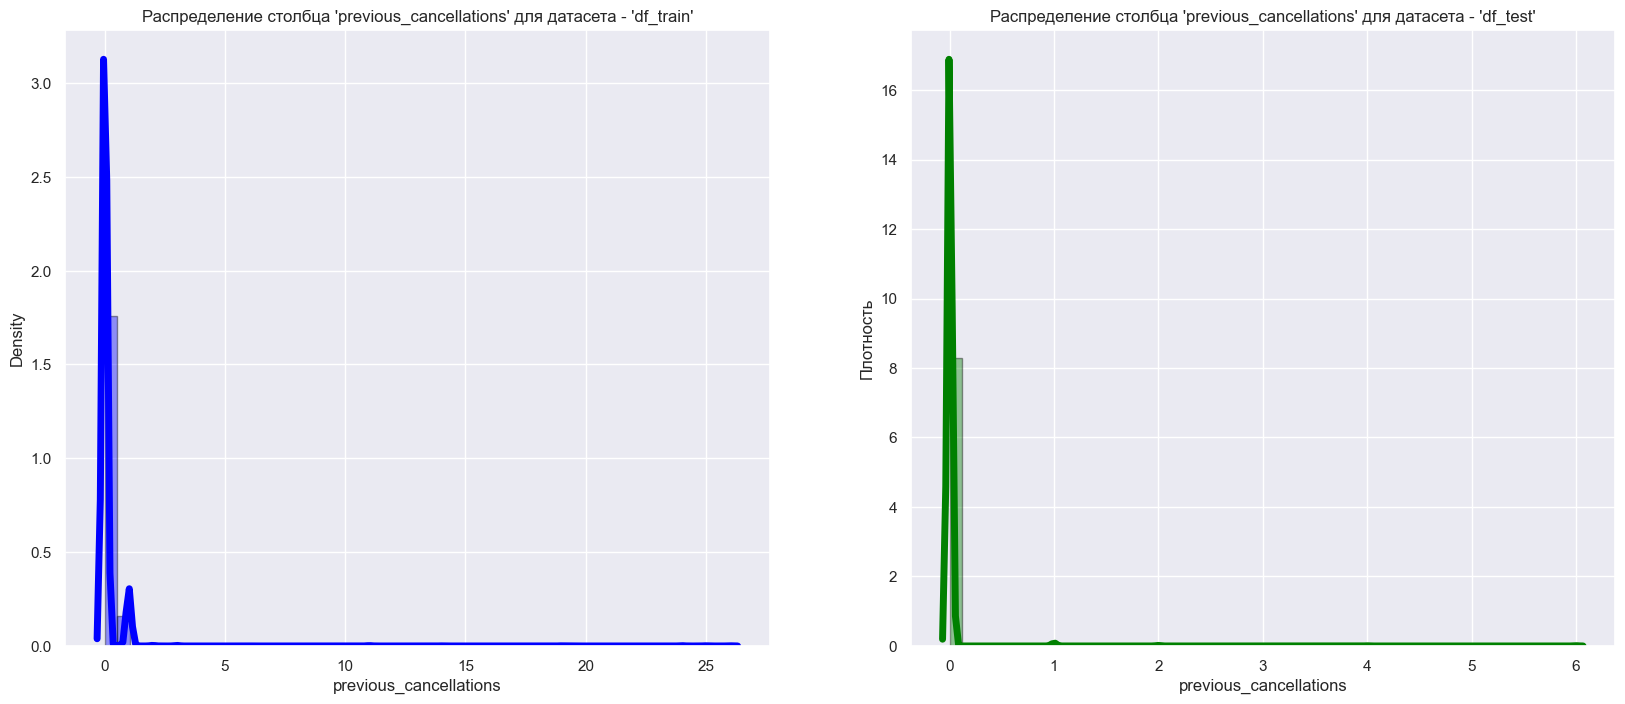

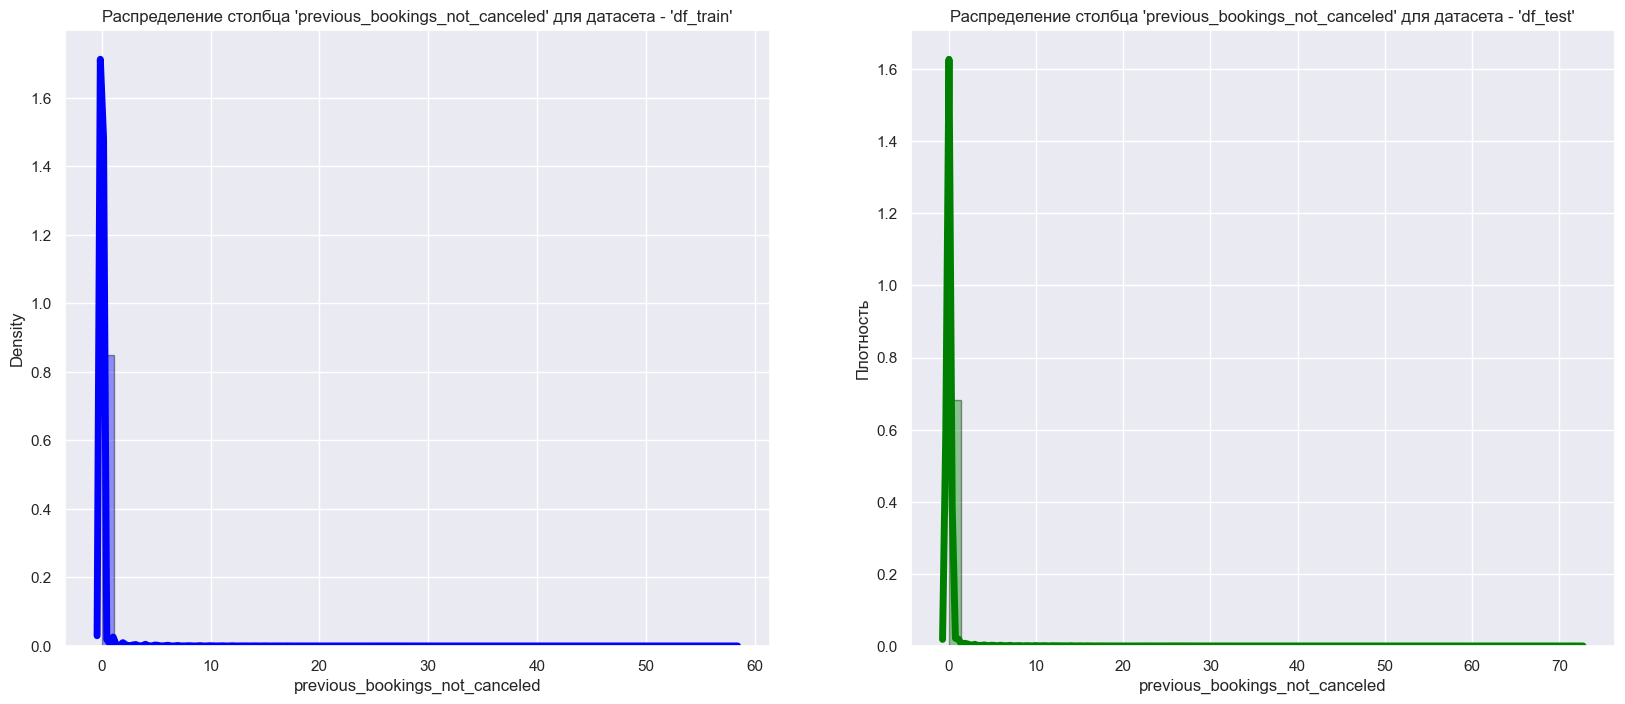

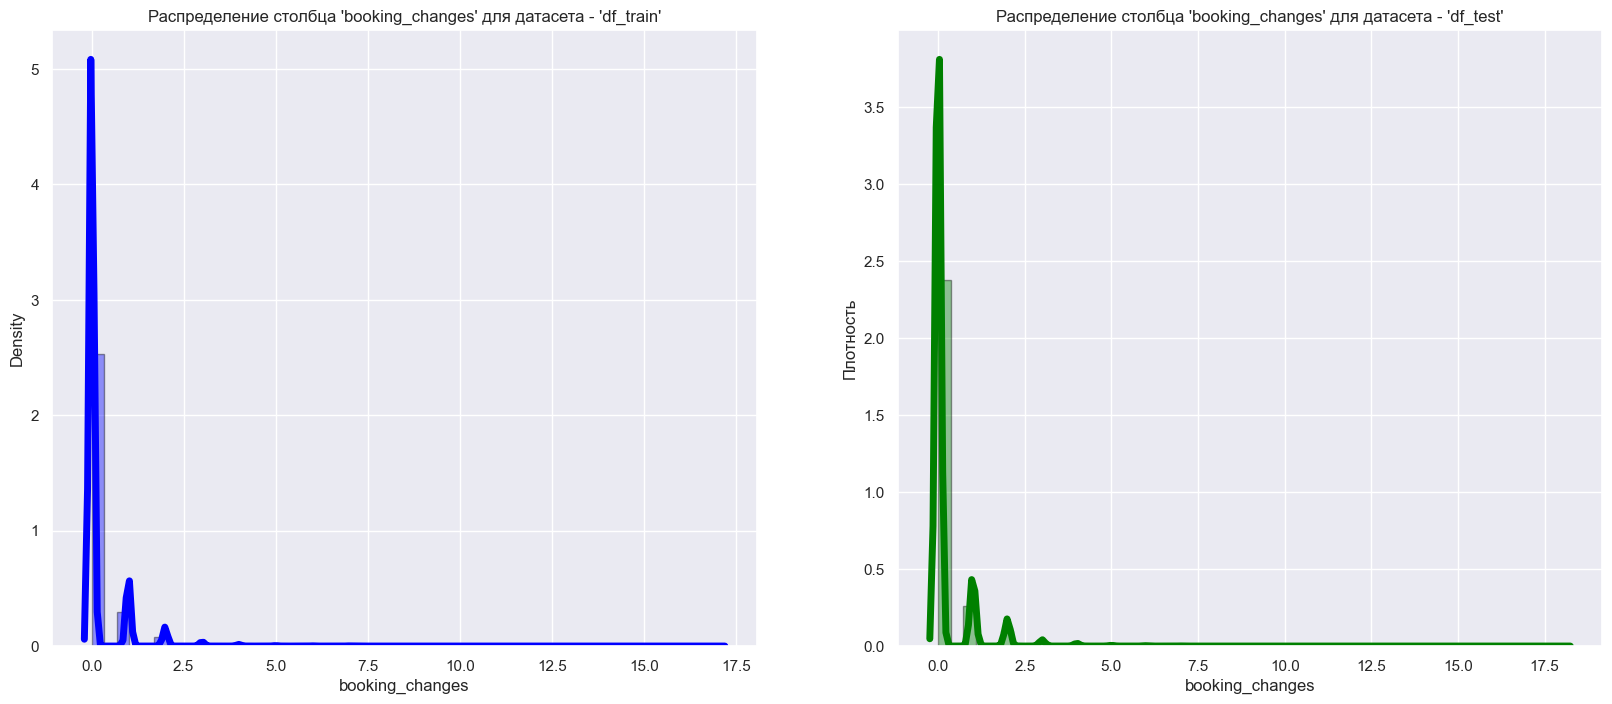

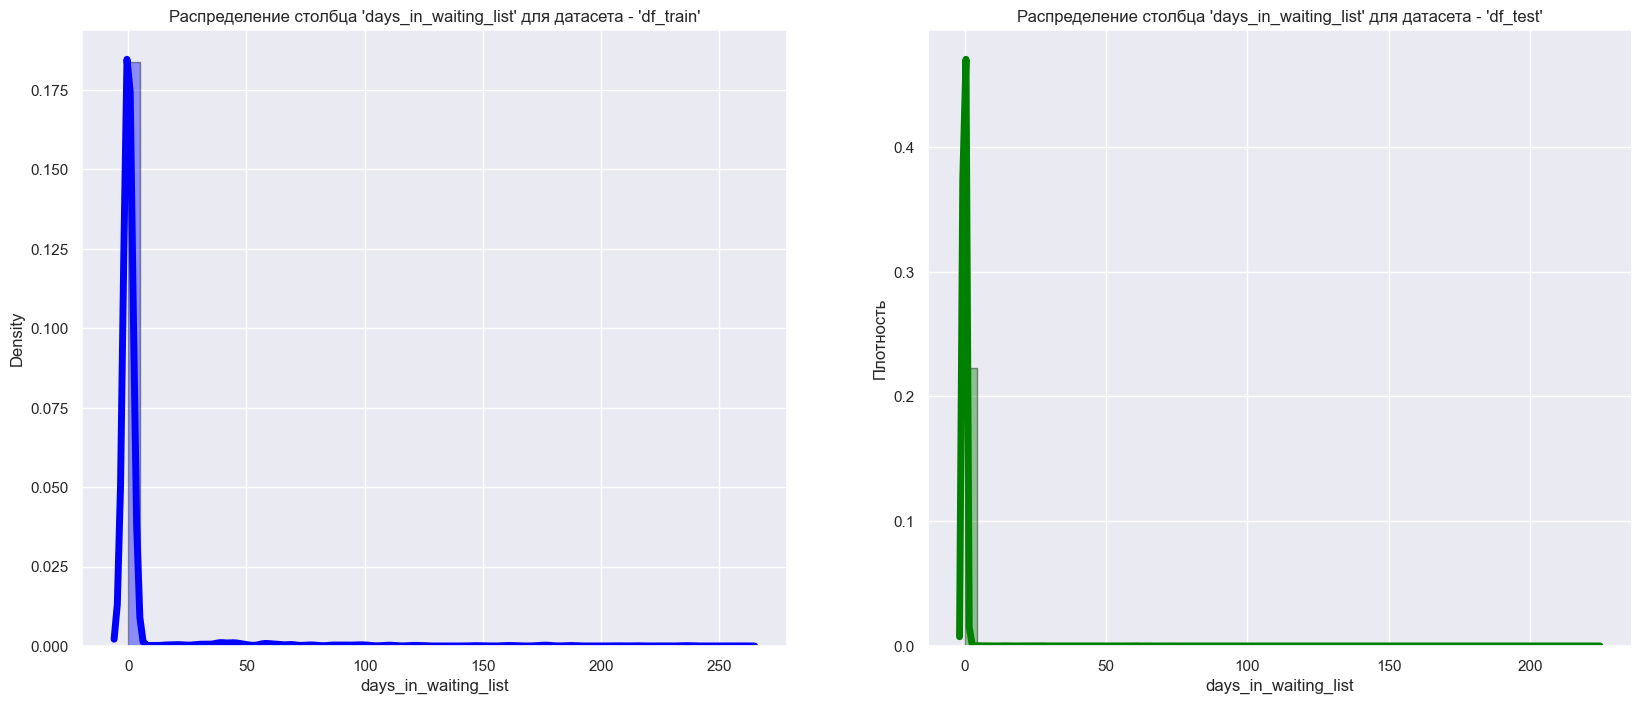

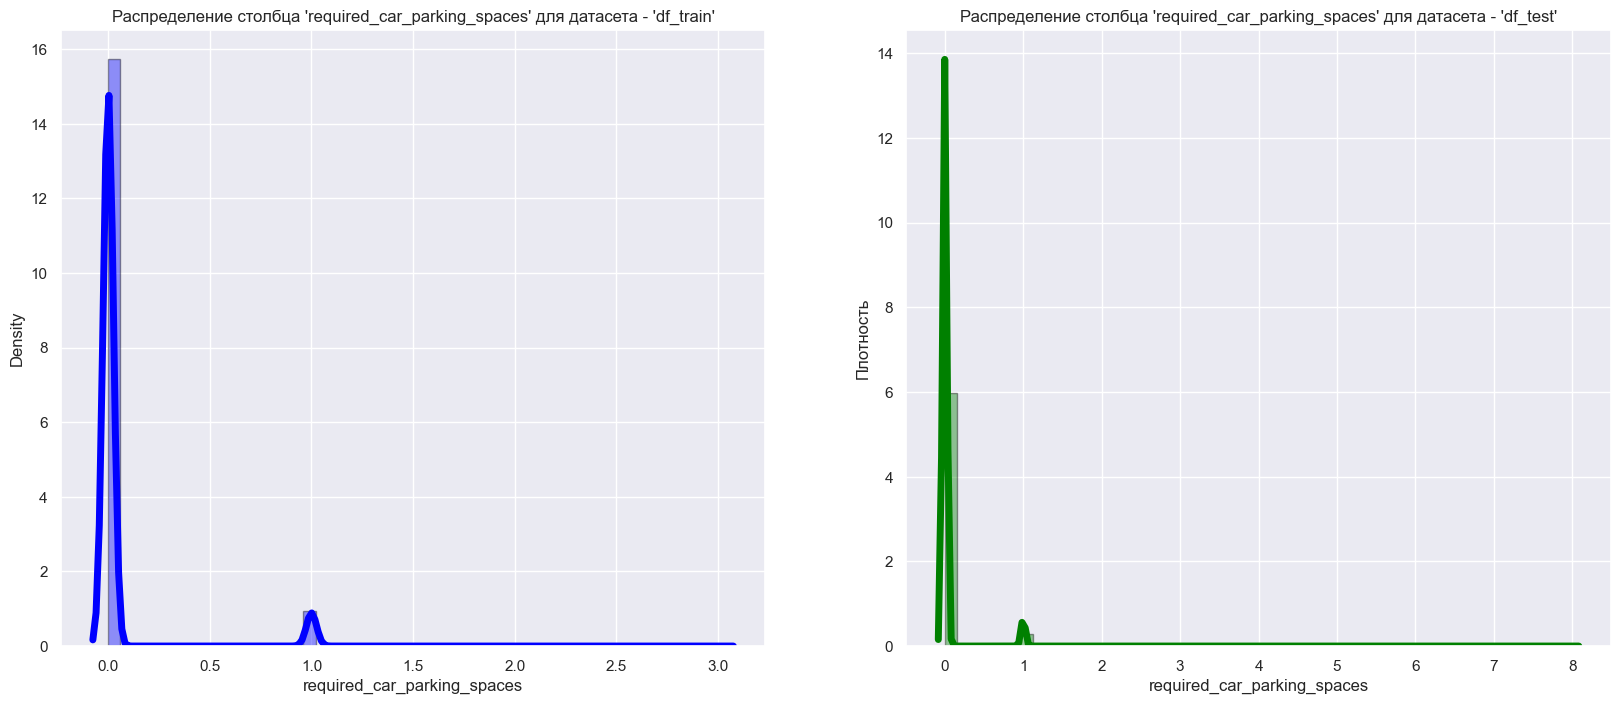

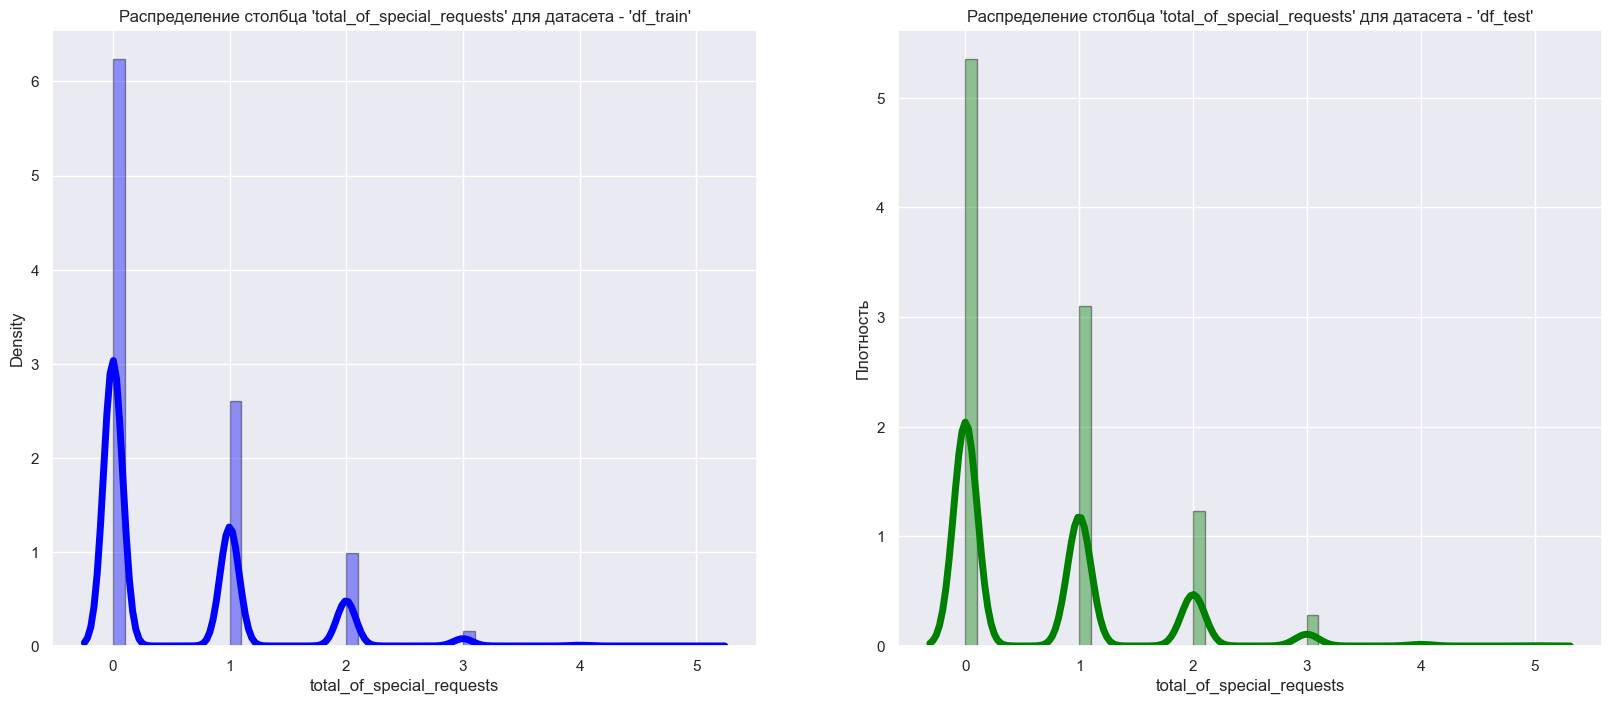

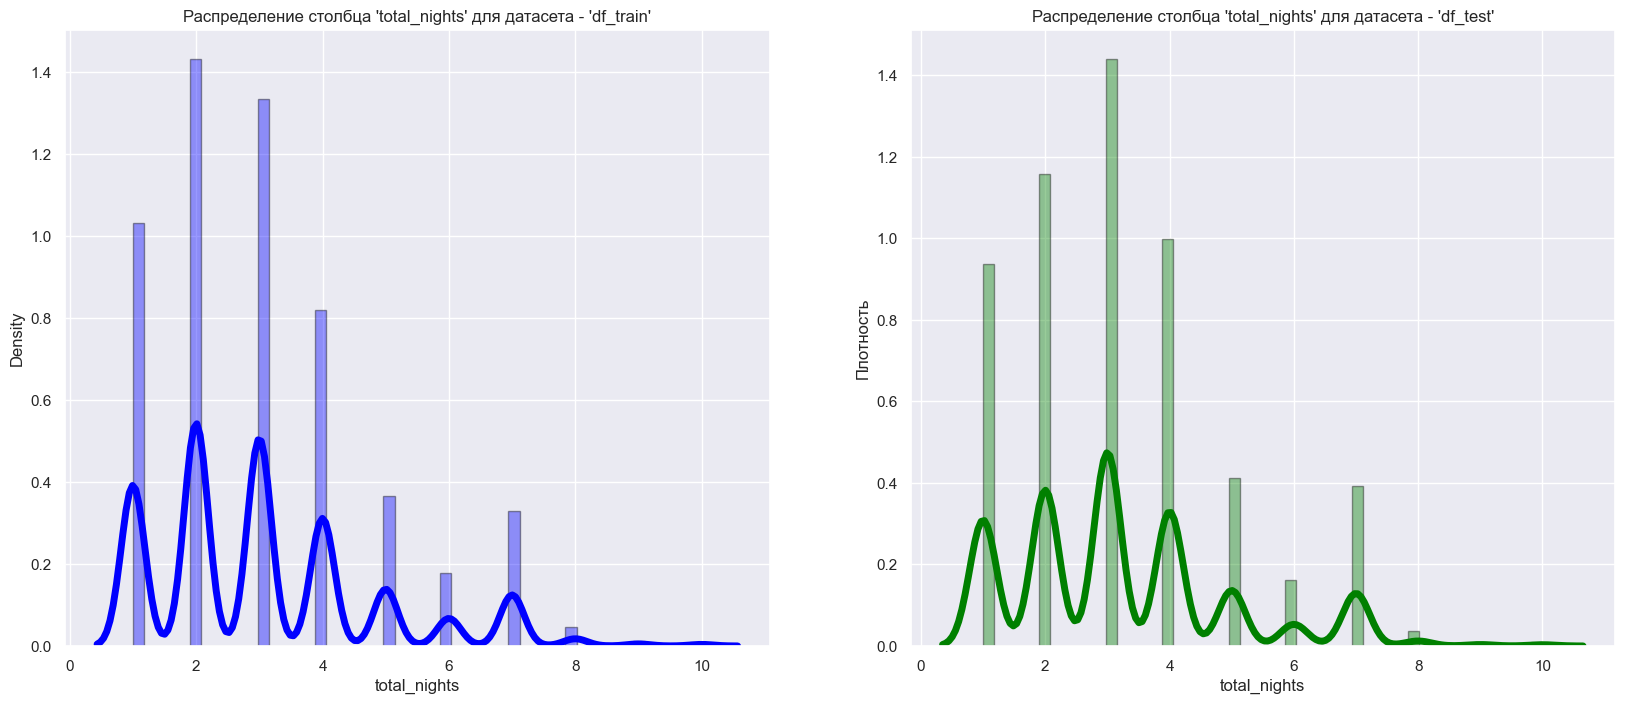

In [43]:
graphs(df_train, df_test)

Судя по графикам, в данных присутствует много выбросов, ибо значения максимальные сильно далеки от средних или медианных значений. <br>
Далее от них обязательно избавимся или отредактируем.

In [44]:
df_train.query('stays_in_weekend_nights > 2 & total_nights < 7 ')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [45]:
df_train.query('previous_cancellations > 3')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6273,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6274,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6275,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6276,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6277,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44345,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44346,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44347,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44348,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3


вероятнее всего, какие-то тестовые данные.. Или же реальные отмены. Выброс

In [46]:
df_test.query('previous_cancellations > 3')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2231,0,134.0,2017,April,15,13,0,3,1.0,0.0,0.0,BB,PRT,Direct,1,4,11,A,0,0,Transient,0,5,3
2232,1,117.0,2017,April,15,13,0,3,1.0,0.0,0.0,BB,PRT,Direct,1,4,11,A,0,0,Transient,0,4,3
2233,0,125.0,2017,April,16,21,2,2,1.0,0.0,0.0,BB,PRT,Direct,1,4,12,A,2,0,Transient,0,4,4
2234,1,132.0,2017,April,17,28,1,2,1.0,0.0,0.0,BB,PRT,Direct,1,4,13,A,0,0,Transient,0,4,3
2512,0,2.0,2017,February,5,1,0,1,1.0,0.0,0.0,BB,PRT,Corporate,1,5,4,A,1,0,Transient,0,0,1
18093,0,0.0,2017,January,1,2,1,2,1.0,0.0,0.0,BB,PRT,Corporate,1,6,58,A,0,0,Transient,0,0,3
18094,0,5.0,2017,January,2,10,0,3,1.0,0.0,0.0,BB,PRT,Corporate,1,6,59,A,0,0,Transient,0,2,3
18095,0,0.0,2017,January,4,24,0,3,1.0,0.0,0.0,BB,PRT,Corporate,1,6,60,A,1,0,Transient,0,1,3
18096,0,1.0,2017,January,5,31,0,3,1.0,0.0,0.0,BB,PRT,Corporate,1,6,61,A,0,0,Transient,0,1,3
18097,0,4.0,2017,May,18,2,0,2,1.0,0.0,0.0,BB,PRT,Corporate,1,6,62,A,1,0,Transient,0,1,2


In [47]:
for data in datas:

    data = data.query('previous_cancellations < 3')

In [48]:
df_train.query('previous_cancellations > 3')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6273,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6274,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6275,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6276,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6277,1,275.0,2015,October,41,4,2,0,1.0,0.0,0.0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44345,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44346,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44347,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3
44348,1,113.0,2016,February,9,25,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,6,0,A,0,44,Transient,0,0,3


In [49]:
df_train.query('previous_bookings_not_canceled >3')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6021,0,5.0,2016,April,15,5,0,2,1.0,0.0,0.0,BB,PRT,Corporate,0,1,4,A,0,0,Transient,0,0,2
6029,0,1.0,2016,November,46,10,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,1,5,A,0,0,Transient,0,0,1
6030,0,39.0,2016,July,29,12,0,1,1.0,0.0,0.0,BB,PRT,Direct,0,0,4,A,1,0,Transient,1,0,1
6033,0,0.0,2016,March,11,8,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,1,4,A,1,0,Transient,1,2,1
6034,0,0.0,2016,April,15,5,0,2,1.0,0.0,0.0,BB,PRT,Corporate,0,1,5,A,1,0,Transient,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58009,0,5.0,2016,November,46,7,1,0,1.0,0.0,0.0,BB,PRT,Corporate,1,0,4,A,0,0,Transient,1,1,1
58010,0,7.0,2016,November,47,17,0,1,1.0,0.0,0.0,BB,PRT,Corporate,1,0,5,A,0,0,Transient-Party,1,1,1
58011,0,3.0,2016,November,48,24,0,1,1.0,0.0,0.0,BB,PRT,Corporate,1,0,6,A,0,0,Transient,0,1,1
58012,0,12.0,2016,December,50,8,0,2,1.0,0.0,0.0,BB,PRT,Corporate,1,0,7,A,0,0,Transient,0,1,2


Как по мне, здесь всё адекватно. 

Столбец booking changes тоже трогать не буду, с человеческими факторами тяжело бодаться и всевозможные варианты вполне реалистичны.

In [50]:
df_train.query('days_in_waiting_list > 50')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1934,0,105.0,2015,November,47,18,2,4,1.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,0,65,Transient-Party,0,0,6
1935,0,105.0,2015,November,47,18,2,4,1.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,0,65,Transient-Party,0,0,6
1936,0,105.0,2015,November,47,18,2,4,1.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,0,65,Transient-Party,0,0,6
1939,0,105.0,2015,November,47,18,2,4,1.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,0,65,Transient-Party,0,0,6
1941,0,105.0,2015,November,47,18,2,4,1.0,0.0,0.0,SC,ESP,TA/TO,0,0,0,A,0,65,Transient-Party,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60824,0,338.0,2016,October,41,7,1,2,1.0,0.0,0.0,BB,DOM,TA/TO,0,0,0,A,0,68,Transient-Party,0,1,3
60826,0,338.0,2016,October,41,7,1,2,1.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,0,68,Transient-Party,0,1,3
61398,0,153.0,2016,October,43,16,2,2,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,1,99,Transient-Party,0,0,4
61642,0,266.0,2016,October,43,21,0,2,1.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,1,74,Transient-Party,0,0,2


In [51]:
def violin_days_waiting(dataset):
    sns.violinplot(dataset['days_in_waiting_list'] ,figsize=(5,10), grid=True)

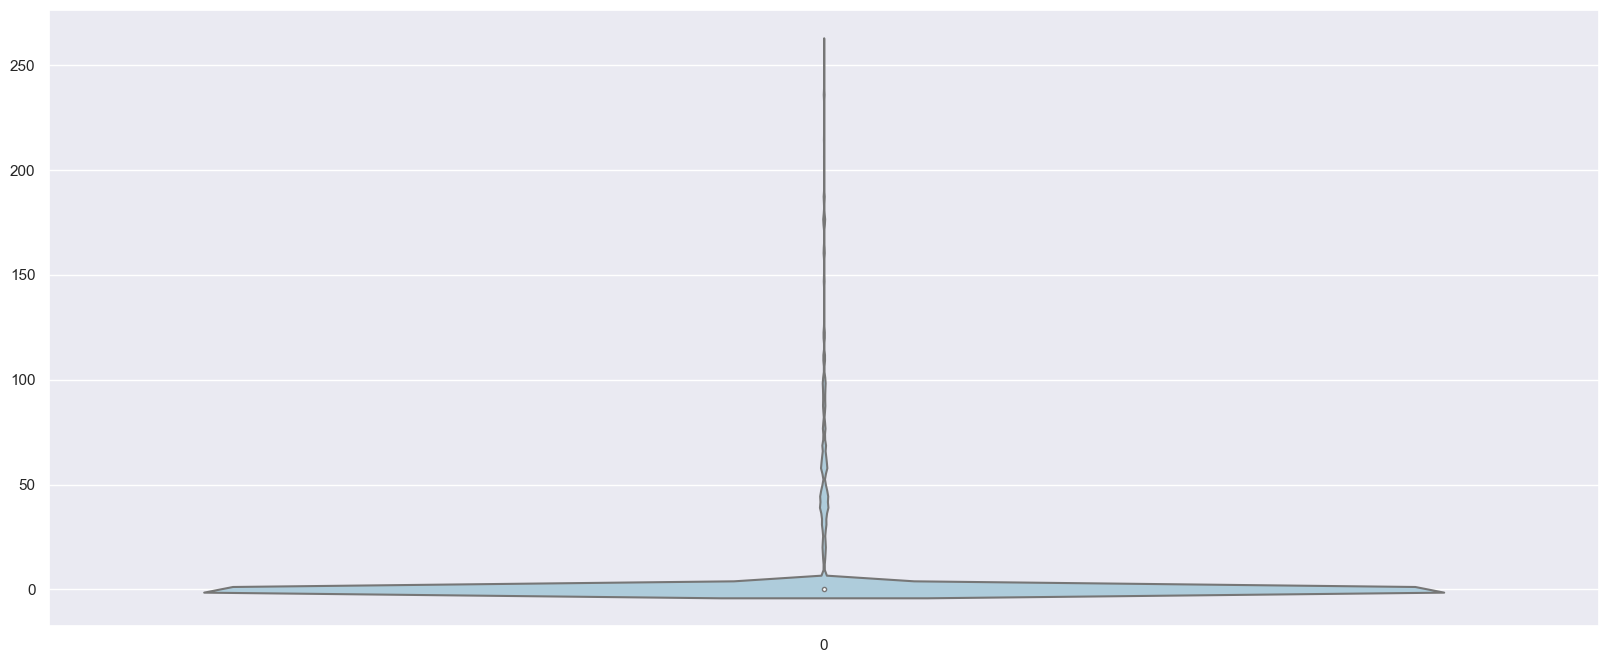

In [52]:
violin_days_waiting(df_train)

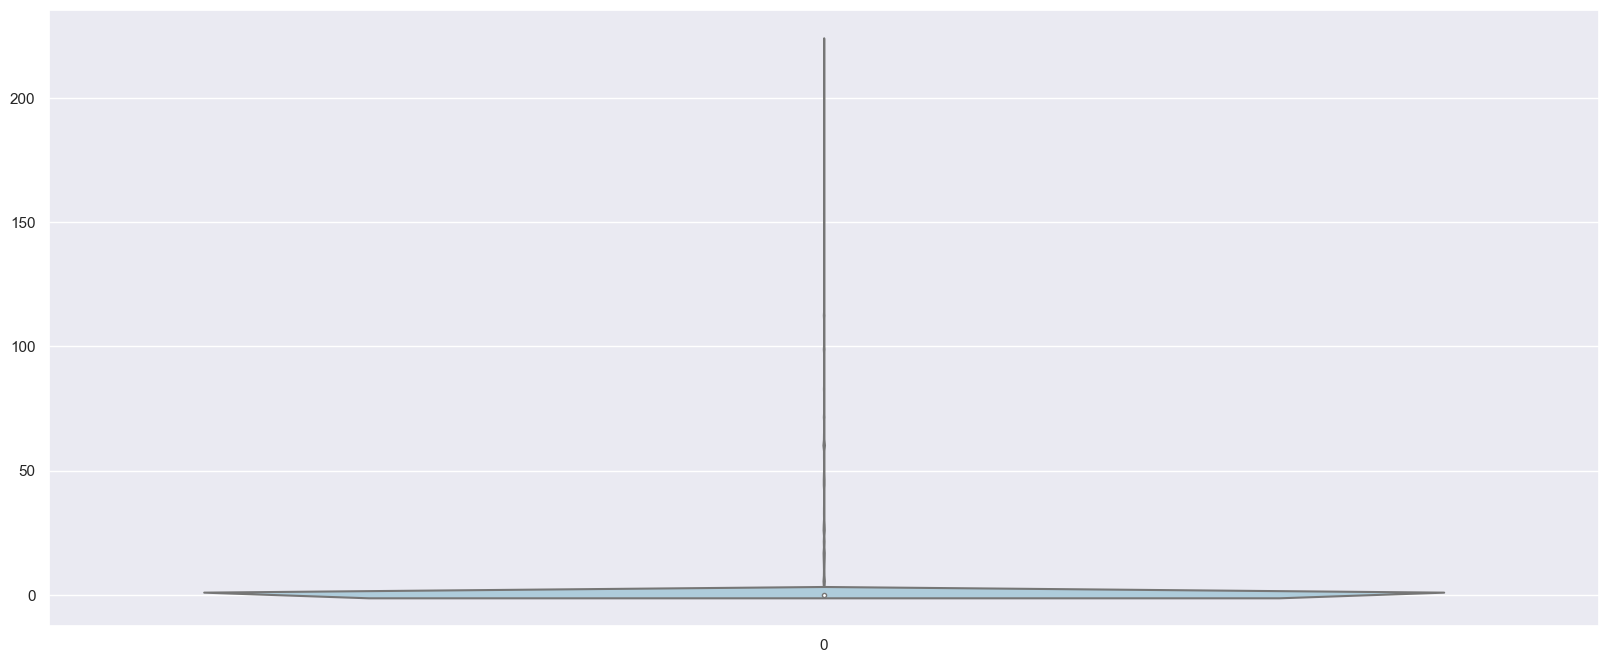

In [53]:
violin_days_waiting(df_test)

In [54]:
df_test.query('days_in_waiting_list > 1')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
390,1,63.0,2017,February,9,28,0,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,14,Transient,0,0,2
456,1,146.0,2017,March,10,9,0,3,1.0,0.0,0.0,SC,PRT,TA/TO,0,0,0,A,0,60,Transient,0,0,3
675,1,252.0,2017,April,14,5,1,4,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,C,4,100,Transient-Party,0,0,5
970,1,221.0,2017,April,17,29,2,1,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,121,Transient-Party,0,0,3
1103,1,217.0,2017,May,19,8,2,5,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,A,2,61,Transient-Party,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26137,0,345.0,2017,May,19,13,2,3,1.0,0.0,0.0,BB,MOZ,TA/TO,0,0,0,A,1,36,Transient-Party,0,0,5
26176,0,34.0,2017,May,20,16,0,3,1.0,0.0,0.0,BB,ESP,TA/TO,0,0,0,A,0,9,Transient-Party,0,0,3
26902,0,344.0,2017,May,21,27,1,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,98,Transient-Party,0,1,2
28600,0,322.0,2017,June,25,23,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,3,59,Transient-Party,0,3,4


In [55]:
x=0
for data in datas:
    if x==0:
        print('df_train')
    else:
        print('df_test')
    print('Среднее кол-во дней ожидания исполнения заказа', data['days_in_waiting_list'].mean())
    print('Медианное кол-во дней ожидания исполнения заказа', data['days_in_waiting_list'].median())
x+=1

df_train
Среднее кол-во дней ожидания исполнения заказа 3.3344218062518207
Медианное кол-во дней ожидания исполнения заказа 0.0
df_train
Среднее кол-во дней ожидания исполнения заказа 0.2623411082315192
Медианное кол-во дней ожидания исполнения заказа 0.0


в 2016 году были явные какие-то сложности с оформлением заказа быстро и средняя сильно отличается от 2017 года. Счесть за выбросы это не получится, ибо это добрые 5% данных, однако же выбросы из df_test точно удалим


In [56]:
df_test = df_test.query('days_in_waiting_list < 1')

In [57]:
df_train.loc[df_train['days_in_waiting_list'] > 1, 'days_in_waiting_list'] = 1

In [58]:
df_test.loc[df_test['days_in_waiting_list'] > 1, 'days_in_waiting_list'] = 1

In [59]:
df_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74.0,2017,January,1,1,1,0,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,1,62.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,1,62.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,1,172.0,2017,January,1,1,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164.0,2017,August,35,31,2,4,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6
32408,0,21.0,2017,August,35,30,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7
32409,0,23.0,2017,August,35,30,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
32410,0,34.0,2017,August,35,31,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7


In [60]:
df_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,1.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,1.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [61]:
df_train.loc[df_train['arrival_date_week_number'] == 1]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2363,1,2.0,2016,January,1,1,0,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,1,1
2364,1,20.0,2016,January,1,1,0,2,2.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,G,0,0,Transient,0,0,2
2365,1,76.0,2016,January,1,1,1,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
2366,0,88.0,2016,January,1,1,0,2,2.0,1.0,0.0,HB,ARG,TA/TO,0,0,0,A,0,0,Transient,0,2,2
2367,1,113.0,2016,January,1,2,0,1,1.0,0.0,0.0,HB,PRT,Direct,0,0,0,A,0,0,Transient,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45292,0,32.0,2016,January,1,1,2,3,1.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,5
45293,0,39.0,2016,January,1,1,2,3,1.0,0.0,0.0,SC,FIN,TA/TO,0,0,0,A,0,0,Transient,0,0,5
45295,0,101.0,2016,January,1,1,2,3,1.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,D,0,0,Transient,0,0,5
45465,0,25.0,2016,January,1,2,2,3,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,5


In [62]:
is_canceled_for_every_week = pd.pivot_table(df_train, index='arrival_date_week_number', values= 'is_canceled' , aggfunc= ('sum'))
is_canceled_for_every_week

,is_canceled
arrival_date_week_number,
1,68
2,57
3,61
4,145
5,153
6,119
7,241
8,370
9,294


<Axes: xlabel='arrival_date_week_number'>

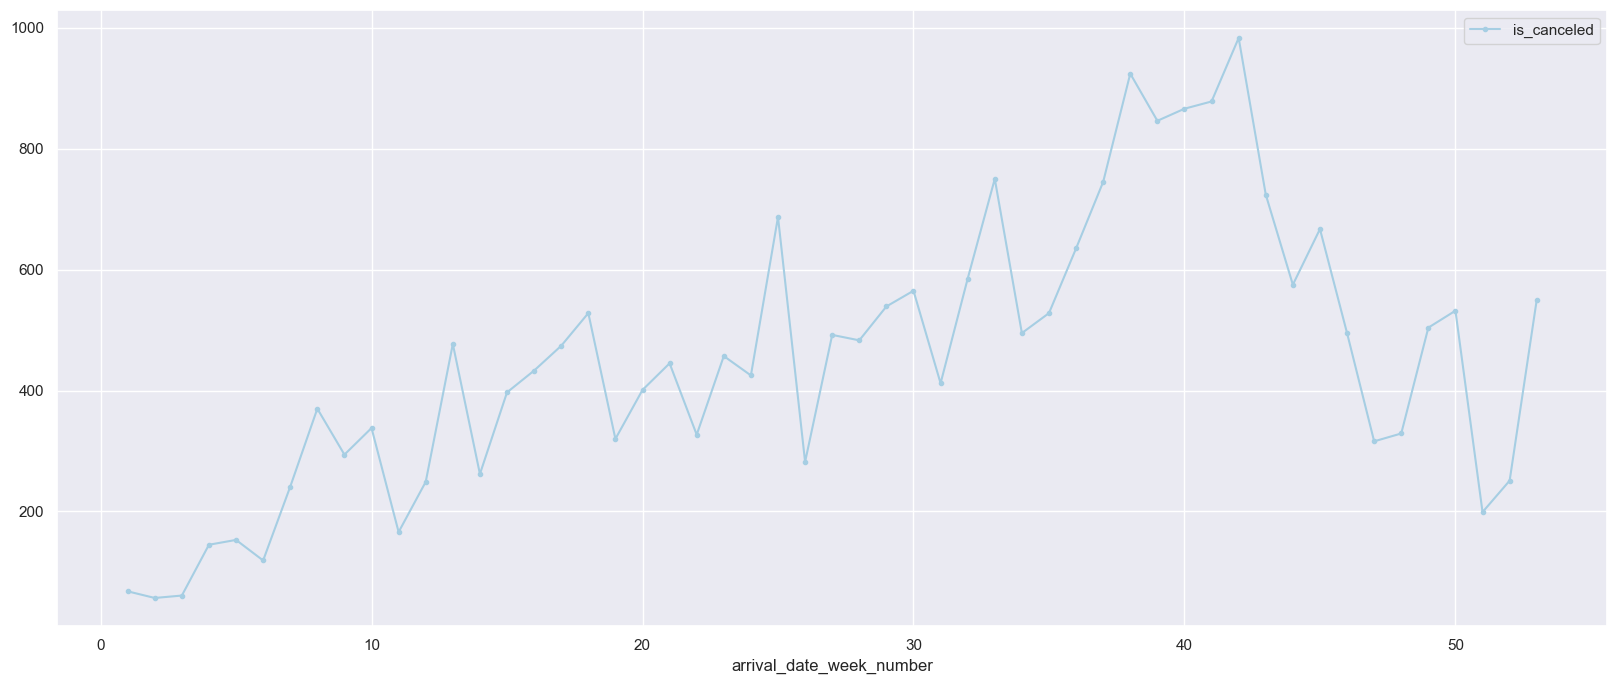

In [63]:
is_canceled_for_every_week.plot( style='.-')

In [64]:
is_canceled_for_every_week.values

array([[ 68],
       [ 57],
       [ 61],
       [145],
       [153],
       [119],
       [241],
       [370],
       [294],
       [338],
       [166],
       [249],
       [477],
       [262],
       [397],
       [433],
       [474],
       [528],
       [320],
       [401],
       [445],
       [327],
       [457],
       [425],
       [687],
       [282],
       [492],
       [483],
       [539],
       [565],
       [412],
       [585],
       [750],
       [495],
       [528],
       [635],
       [745],
       [924],
       [846],
       [866],
       [878],
       [983],
       [724],
       [575],
       [667],
       [495],
       [316],
       [329],
       [504],
       [532],
       [199],
       [251],
       [550]], dtype=int64)

In [65]:
def lead_time_violin(dataset):
    sns.violinplot(dataset['lead_time'] ,figsize=(5,10), grid=True, legend=True)
    plt.title('Размах количества дней между датой бронирования и прибытия')
    plt.show()

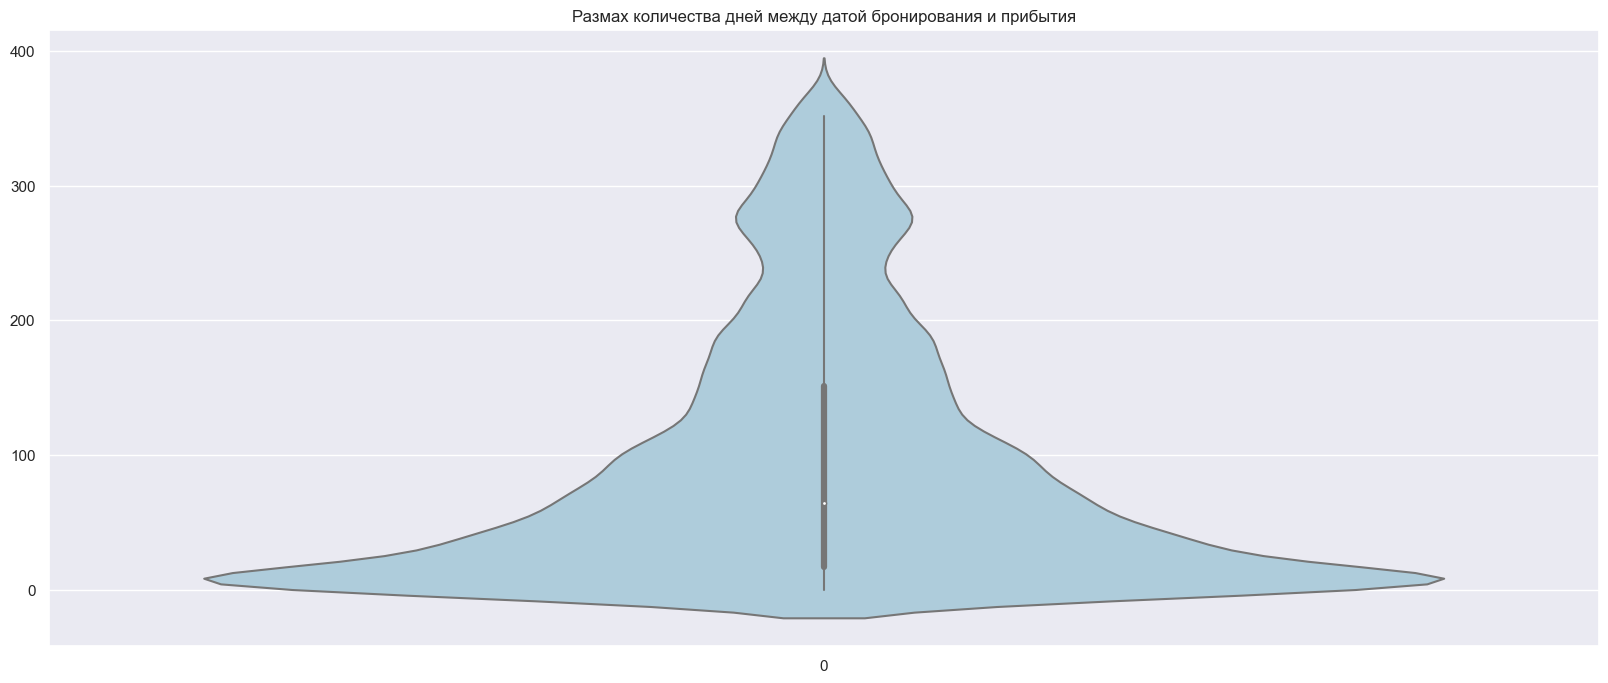

In [66]:
#df_train
lead_time_violin(df_train)

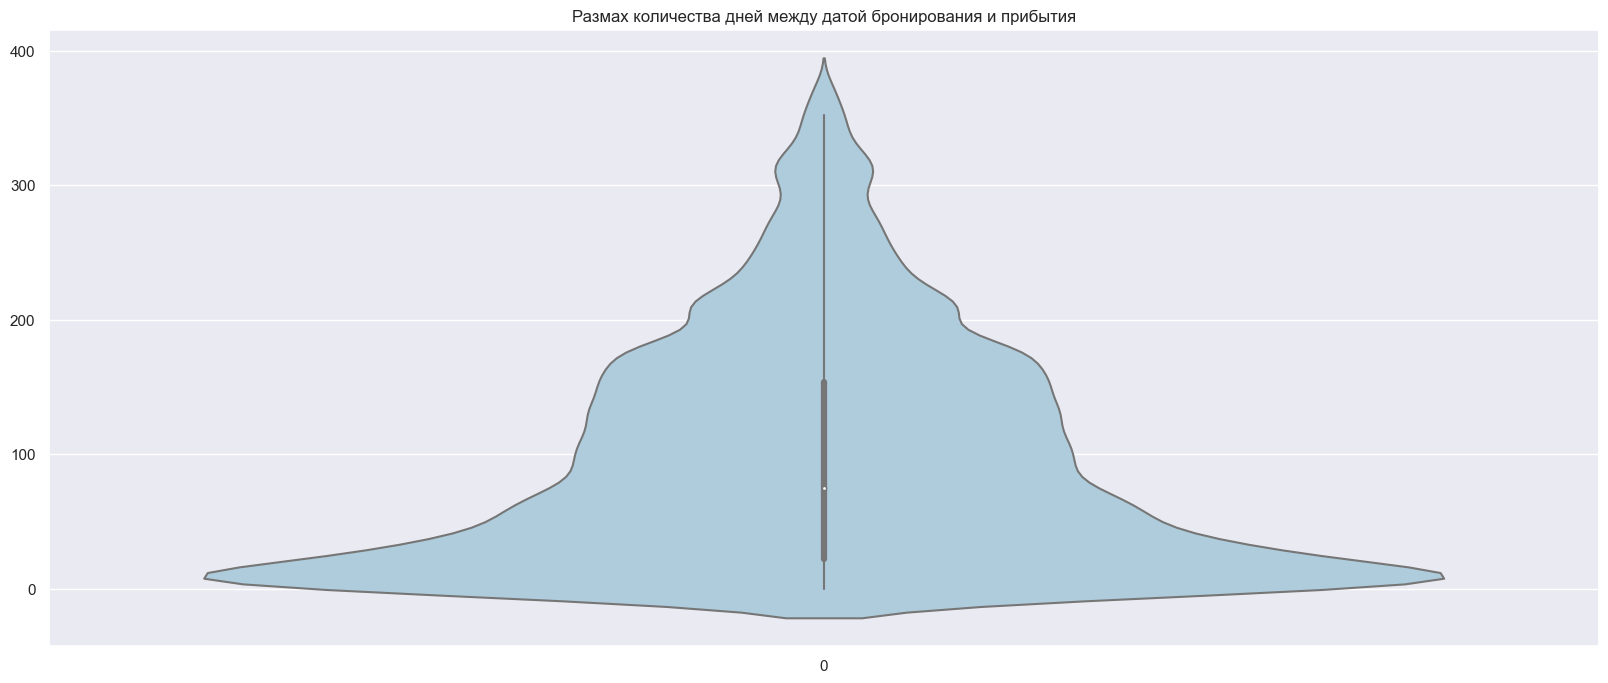

In [67]:
#df_test
lead_time_violin(df_test)

In [68]:
print( 'Медианное значение lead_time для df_train',df_train['lead_time'].median())
print( 'Медианное значение lead_time для df_test', df_test['lead_time'].median())
print( 'Максимальное значение lead_time для df_train', df_train['lead_time'].max())
print( 'Максимальное значение lead_time для df_test', df_test['lead_time'].max())

Медианное значение lead_time для df_train 64.0
Медианное значение lead_time для df_test 75.0
Максимальное значение lead_time для df_train 374.0
Максимальное значение lead_time для df_test 373.0


Значение максимальное очень далеки от медианых в столбце lead_time обоих датафреймов. <br>
Если медианы для датафреймов df_train и df_test равны: 64 и 76 соответственно, то макс значение их: 374 и 373. 


In [69]:
df_test.query('lead_time > 350' )

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
662,1,364.0,2017,April,14,3,1,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,4
703,1,351.0,2017,April,14,8,2,5,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,7
709,1,351.0,2017,April,14,8,2,5,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,7
712,1,351.0,2017,April,14,8,2,5,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,7
713,1,351.0,2017,April,14,8,2,5,1.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28838,0,368.0,2017,June,26,28,0,3,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient-Party,0,1,3
28840,0,368.0,2017,June,26,28,0,3,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient-Party,0,1,3
28875,0,368.0,2017,June,26,28,0,3,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient-Party,0,1,3
30533,0,352.0,2017,July,30,27,0,3,2.0,1.0,0.0,BB,NLD,TA/TO,0,0,0,B,2,0,Transient,0,1,3


violin plot показывает выбросами все, что выше приблизительно 350. Думаю, что можно удалить выбросы, их всего 567, что менее 1% всех значений для df_train. 

In [70]:
df_train = df_train.query('lead_time < 350')

In [71]:
df_test = df_test.query('lead_time < 350')

In [72]:
sns.set(rc={'figure.figsize':(10, 12)})

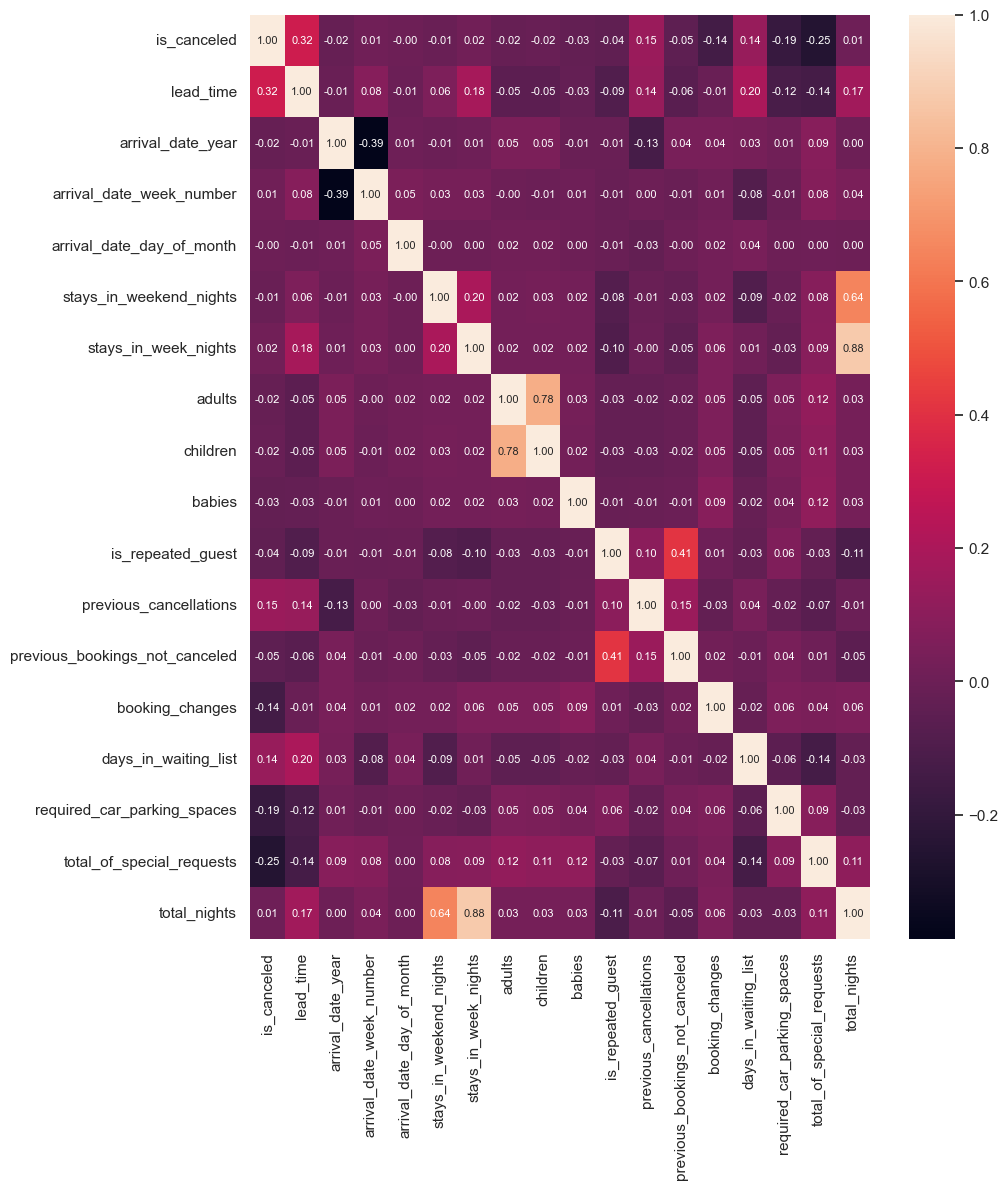

In [73]:
sns.heatmap(df_train.corr(),  annot= True, annot_kws = {"size":8}, fmt='.2f' )
plt.show()

Из такой тепловой карты не ясно ничего, однако все равно некоторые столбцы выделяются высокой зависимостью к столбцу is_canceled. <br>
Будем детально смотреть этот столбец, пренебрегая отрицательной зависимостью и положительной. <br>
Нужно увидеть самые ключевые признаки для целевого.

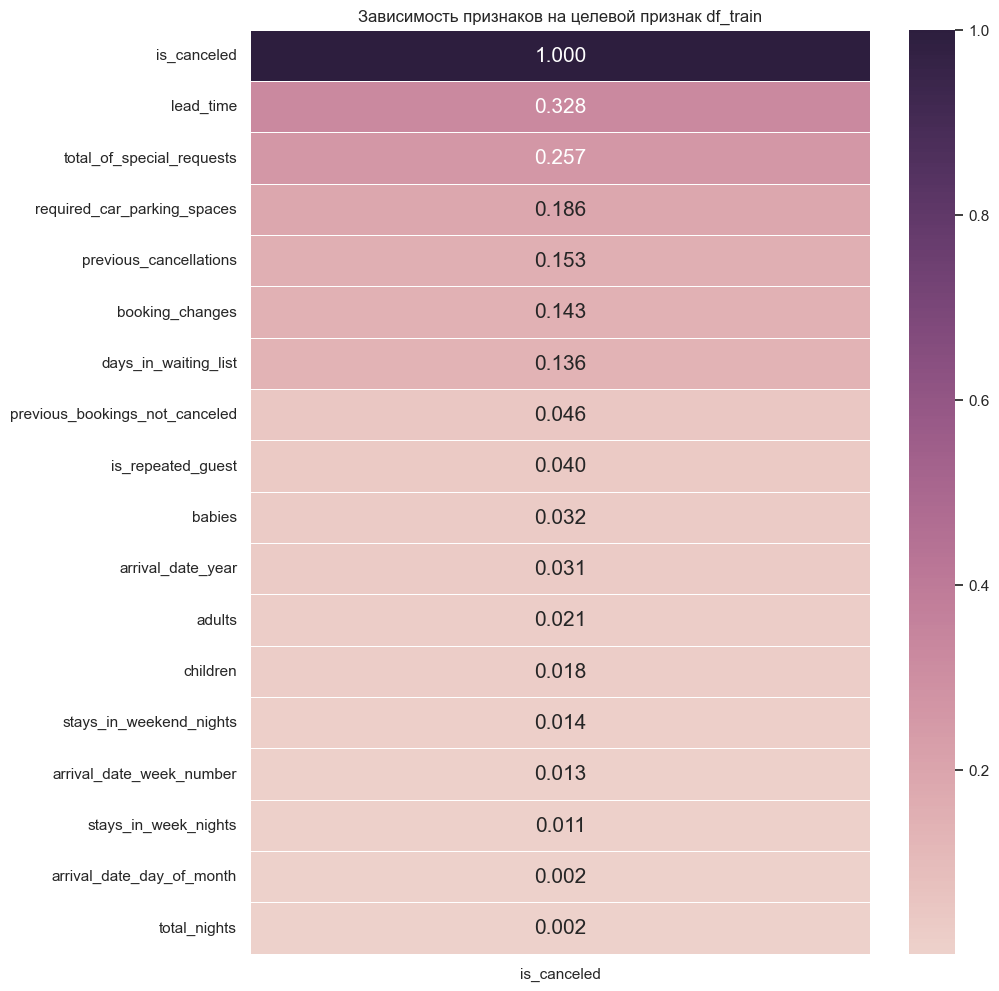

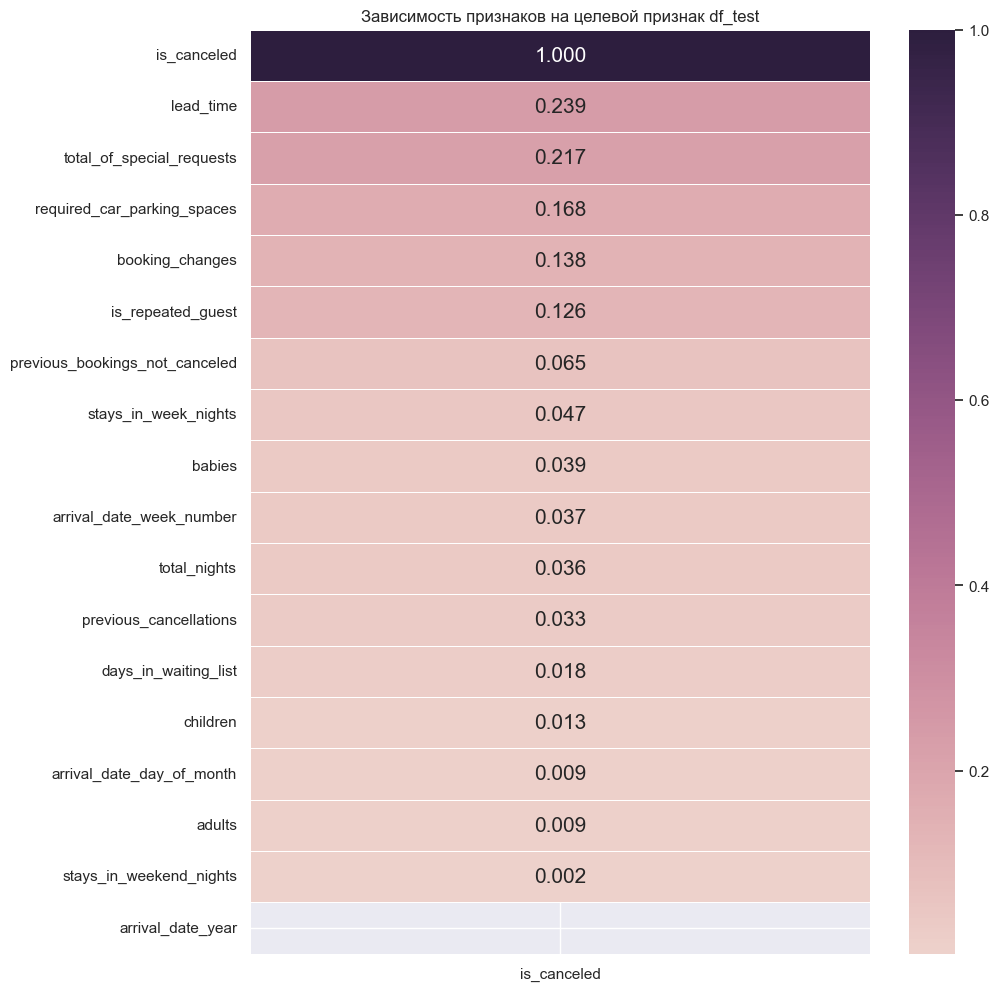

In [74]:
y = 0
for df in datas:
    ax = sns.heatmap(df.corr()[['is_canceled']].abs().sort_values('is_canceled', ascending=False),
                    annot = True,
                annot_kws = {"size":15}, 
                cmap=sns.cubehelix_palette(as_cmap=True), 
                fmt='.3f',  linewidth=.5)
    if y == 0:
        x = 'df_train'
    else:
        x = 'df_test'  
    ax.set_title(f'Зависимость признаков на целевой признак {x}')
    plt.show()
    y+=1

In [75]:
top_corr = [ "total_of_special_requests", 'required_car_parking_spaces', 'previous_cancellations', 'booking_changes']

Нужно изобразить сумму is canceled на каждую неделю <br> 
Нужно изобразить график по первым трем корреляциям. 


In [76]:
top_corr = [ "total_of_special_requests", 'required_car_parking_spaces', 'previous_cancellations', 'booking_changes']

In [77]:
def graphs_top_corr(data):
    for column in top_corr:
        pd.pivot_table(data, index=df_train[column], values= 'is_canceled' , aggfunc= ('sum')).plot( style='.-')
        plt.title('Распределение отказов с привязкой к столбцу {}'.format(column))
    

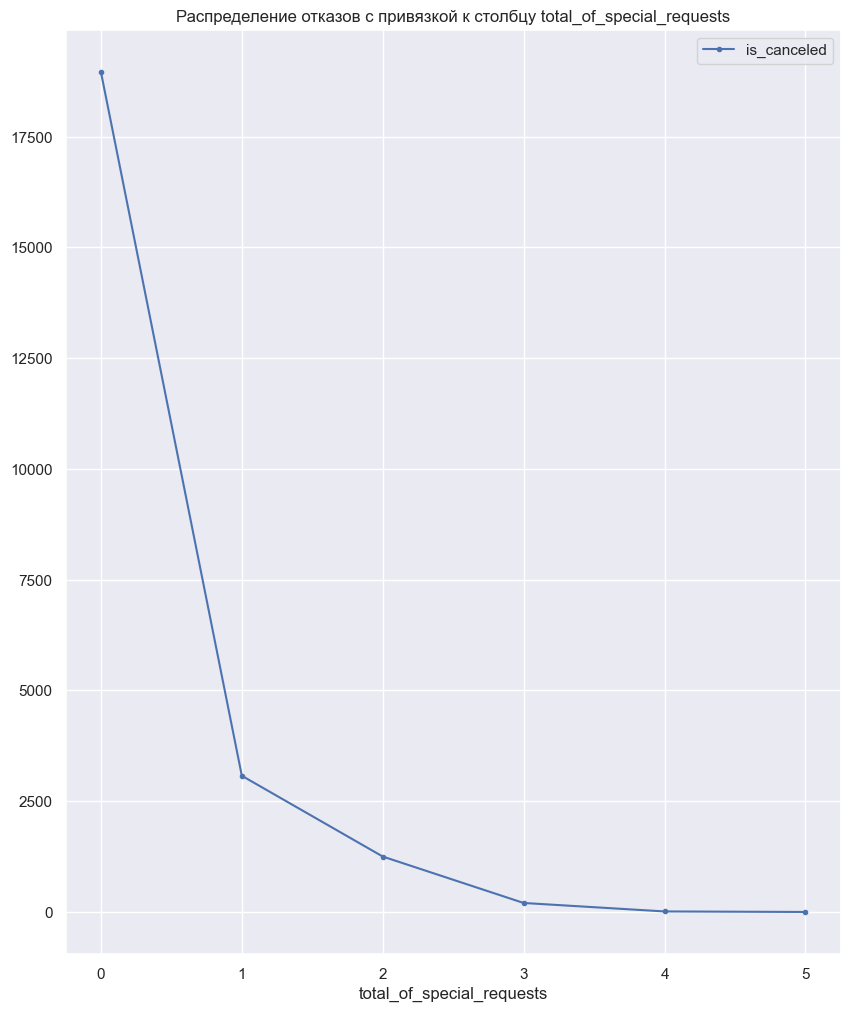

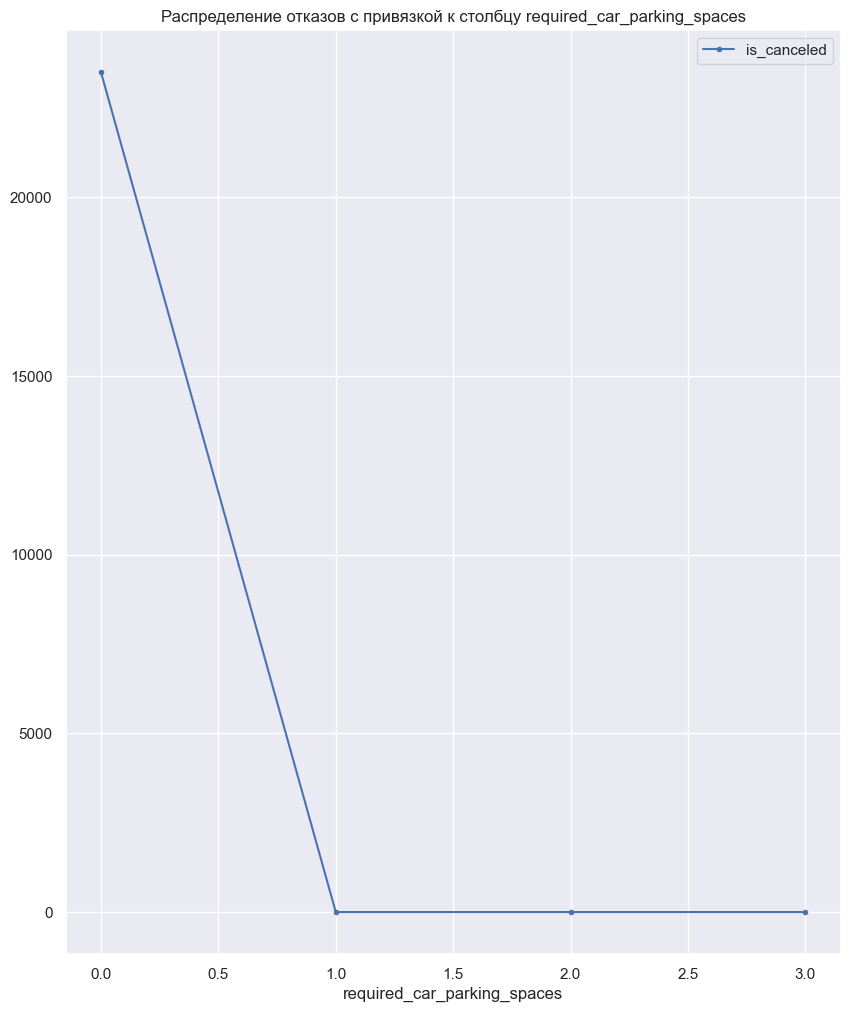

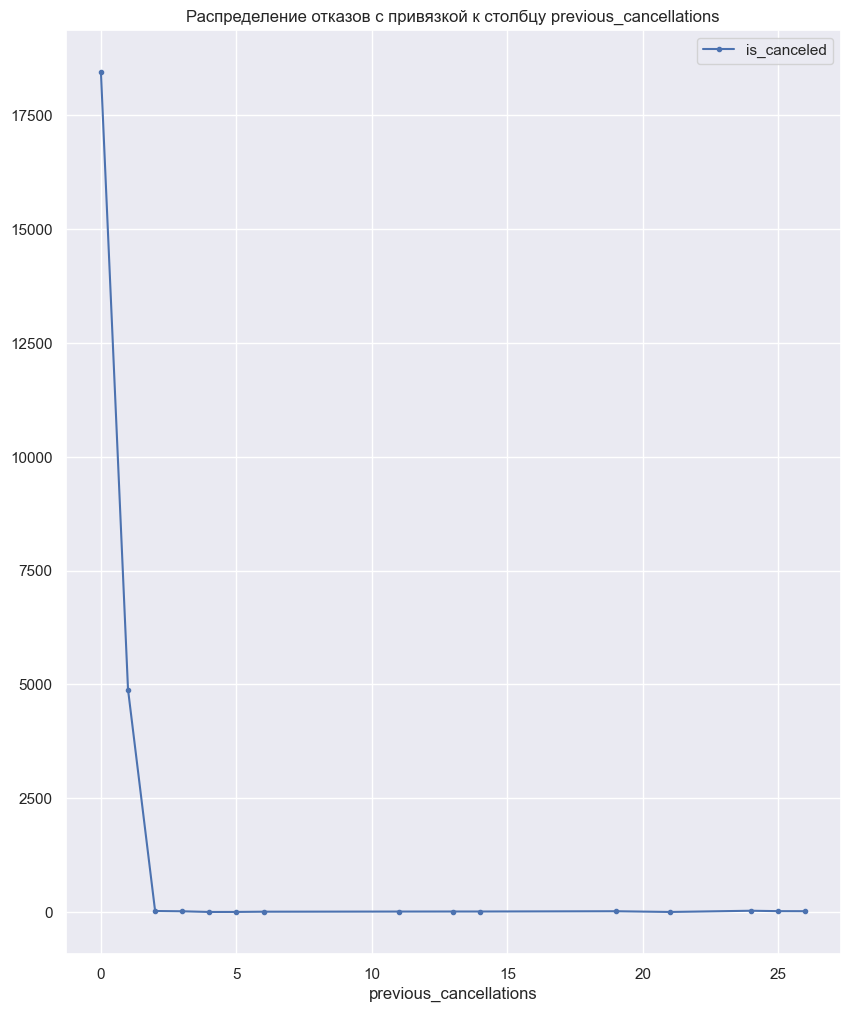

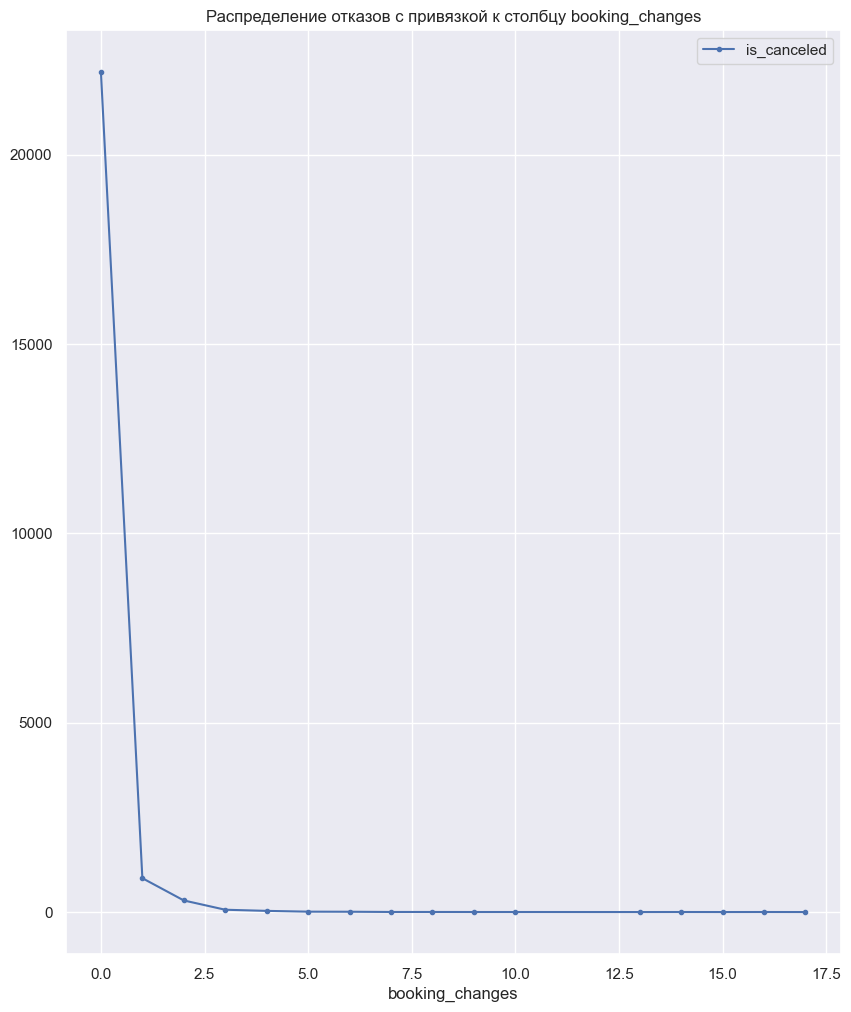

In [78]:
#top corr Без учета столбца lead_time Для датасета df_train
graphs_top_corr(df_train)

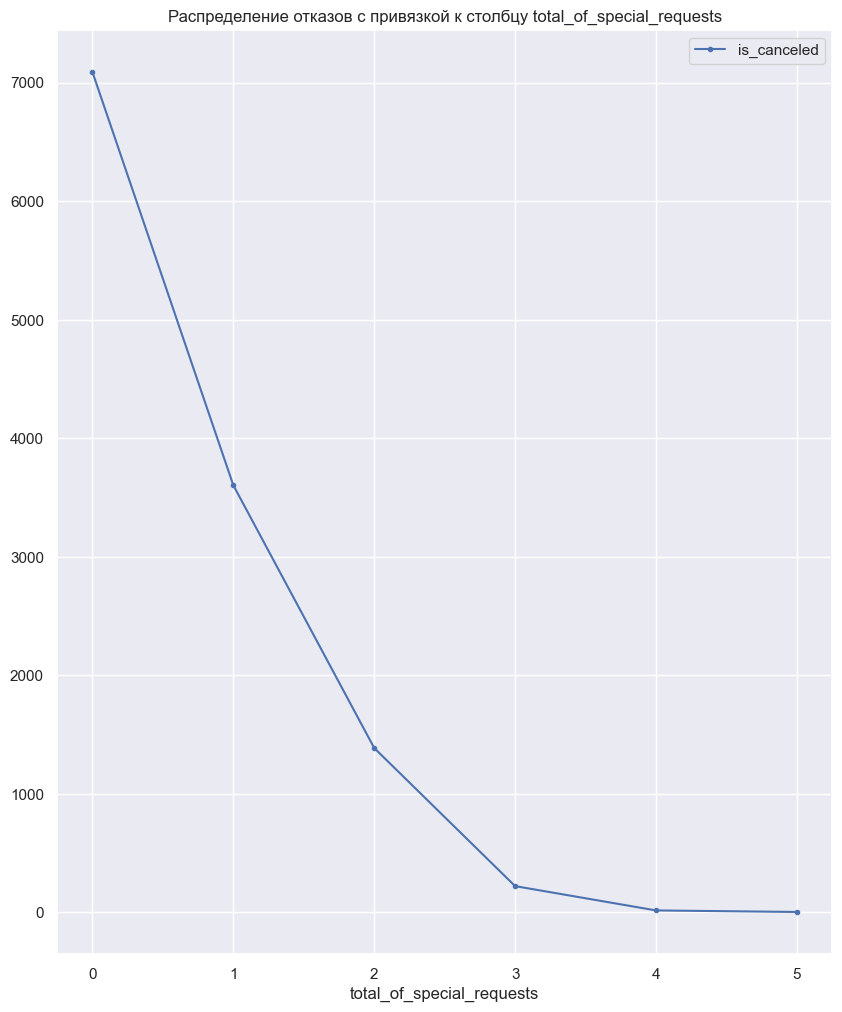

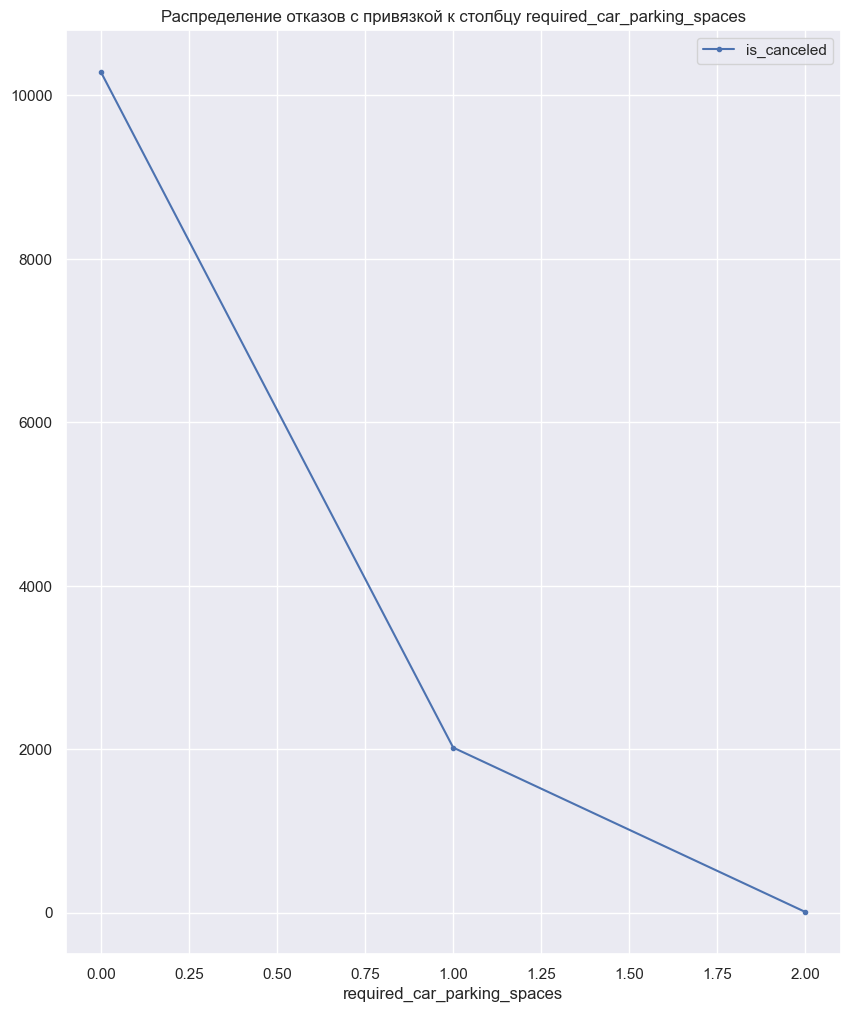

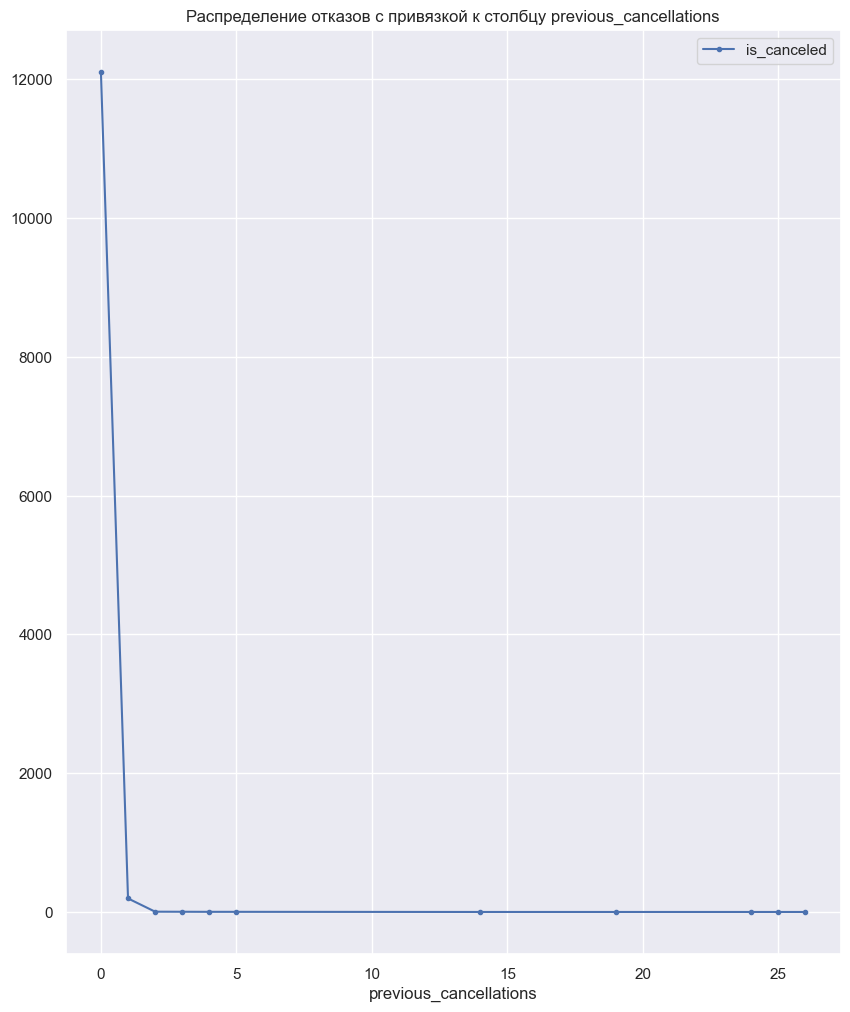

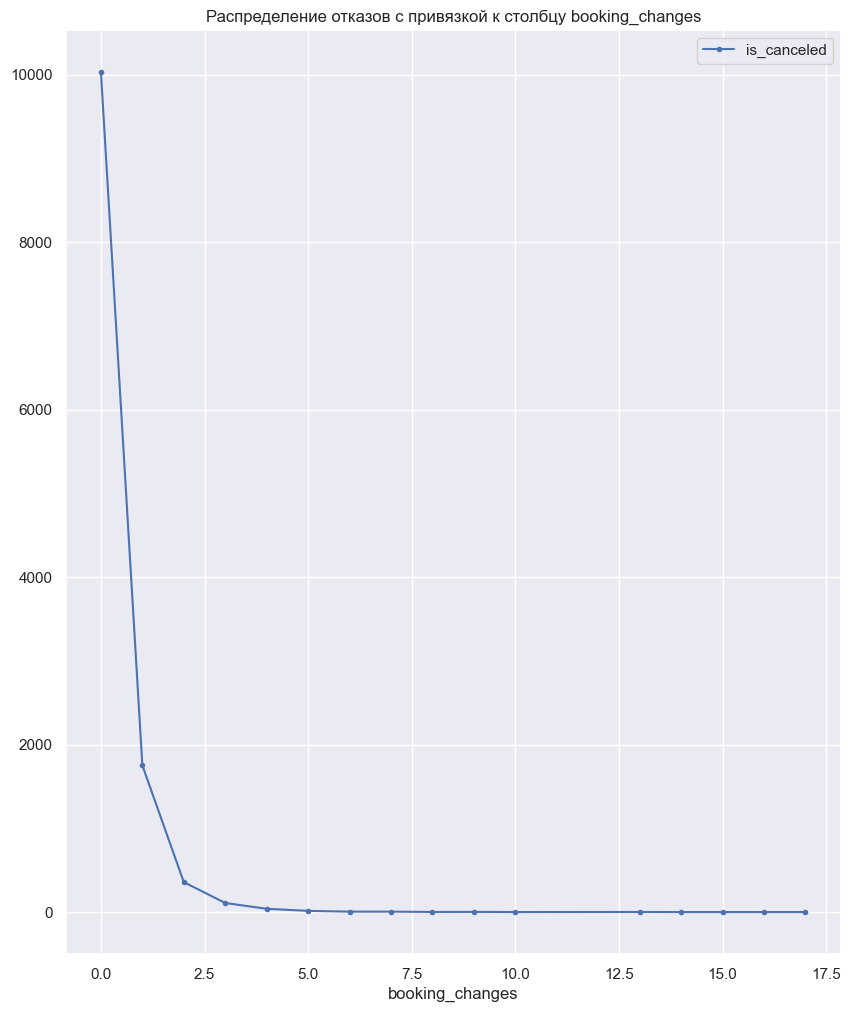

In [79]:
#top corr Без учета столбца lead_time Для датасета df_test
graphs_top_corr(df_test)

Построили графики по самым ключевым для целевого признака столбцам. <br>
И судя по всему, по мере увеличения значений в вышеуказаных столбцах - снижается факт отмены бронирования.


Думаю, можно применить метод standart scaller, чтобы эти столбцы оказывали не максимальное влияние, а умеренно среднее. 

## Формулировка ML-задачи на основе бизнес-задачи

Система бронирования предусматривает 80% оплату депозита при определении моделью ML предсказанную отмену от брони. <br>
Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.


В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. <br>
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.<br>
На разработку системы прогнозирования заложен бюджет — 400 000. 

In [80]:
df_for_revenue = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                        'price_for_night': [1000, 800, 600, 550, 500, 450, 350], 
                       'price_for_service': [400, 350, 350, 150, 150, 150, 150]})

In [81]:
def row_revenue(row):
    room = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['stays_in_week_nights'] + row['stays_in_weekend_nights']
    
    price = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_night'].median()
    cost = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_service'].median()
    
    if (row['is_canceled'] == 0):
        nights_with_service =  math.floor((total_nights-1)/2)
        if month in ['December', 'January', 'February']:
            revenue = price* total_nights - cost - cost*nights_with_service
        elif month in ['June', 'July', 'August']:
            revenue = 1.4*price* total_nights - cost - cost*nights_with_service
        else:
            revenue = 1.2*price* total_nights - cost - cost*nights_with_service
            
    if (row['is_canceled'] == 1):
        if month in ['December', 'January', 'February']:
            revenue = - price - cost 
        elif month in ['June', 'July', 'August']:
            revenue = - (1.4*price) - cost
        else:
            revenue = -(1.2*price) - cost   
    return revenue

In [82]:
total_revenue_df_train = df_train.apply(row_revenue, axis=1).sum()
print('Сумма прибыли за 2016 год: ', total_revenue_df_train)

Сумма прибыли за 2016 год:  72499550.0


In [83]:
total_revenue_df_test = df_test.apply(row_revenue, axis=1).sum()
print('Сумма прибыли за 2017 год: ', total_revenue_df_test)

Сумма прибыли за 2017 год:  35209660.0


Посчитали прибыль по двум датафреймам. Теперь задача загрузки данных в модель и прогнозирование прибыли с учетом новой системы уплаты предоплаты при отрицательном прогнозе модели для клиента. <br>
Заодно составим картину признаков «ненадёжного» клиента

##  Разработка модели ML


В виде основной метрики, по которой мы будем оценивать наши модели, будет использована - f1 score, <br>
f1 score является средним значением accuracy и recall. <br>

$\large\ F1score = \frac{2*accuracy*recall}{accuracy+recall}$

Recall, как метрика, очень хороша, однако при тестировании были замечены неприятные моменты, при которых модели с высоким показателем Recall имели низкий показатель accuracy. <br>
Поэтому в купе с accuracy в виде метрики f1 - будет лучший выбор. 
как по мне, в данной ситуации, f1 - это лучшая метрика, которая сможет максимизировать прибыль, <br>
ибо чем выше показатель recall и accuracy, тем больше денег модель сможет позволить сэкономить. 

Данные нужно подготовить, для двух датафреймов нужно выделить целевой признак. 

In [84]:
df_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,1.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,1.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


**is_canceled**	 столбец будет target, а для features мы выкинем некоторые бесполезные столбцы и сам целевой признак.  <br>
К примеру, информация о месяце - **arrival_date_month** и **arrival_date_day_of_month**  и **arrival_date_year** по сути бесполезны потому, что у нас есть столбец **arrival_date_week_number**, который отображает всю нужную информацию для нас. <br>
Также можно убрать столбец **total nights**, ведь по сути это результат сложения столбцов **stays_in_weekend_nights** и **stays_in_week_nights**	

In [85]:
df_train.query('total_nights != stays_in_week_nights + stays_in_weekend_nights')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [86]:
df_test.query('total_nights != stays_in_week_nights + stays_in_weekend_nights')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [87]:
df_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [88]:
columns_for_features = ['lead_time',
       'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests']


In [89]:
target_train = df_train['is_canceled']
target_test = df_test['is_canceled']
features_train = df_train[columns_for_features]
features_test = df_test[columns_for_features]

Мы будем использовать метод кодирования данных - прямой, ибо порядковое кодирование не подходит для модели логистической регрессии. 

In [90]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(features_train)
features_train = ohe.transform(features_train)
features_test = ohe.transform(features_test)

Далее приступим к созданию модели Логистической регрессии.

In [91]:
RANDOM_STATE = 12345

In [92]:
solver_LR_list = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

In [93]:
for solver_LR in solver_LR_list:
    model_LR = LogisticRegression(random_state= RANDOM_STATE, solver=solver_LR, class_weight='balanced')
    score = cross_validate(model_LR,features_train, target_train, cv=5, scoring= 'f1')
    best = sum(score['test_score']) / len(score['test_score'])
    print(f'Лучший результат: {best} для метода {solver_LR}')

Лучший результат: 0.5441081038578908 для метода lbfgs
Лучший результат: 0.5424797521441016 для метода liblinear
Лучший результат: 0.5426412403793061 для метода newton-cg
Лучший результат: 0.5425422427480084 для метода sag
Лучший результат: 0.5425042027840107 для метода saga


Лучший показатель f1 score для логистической регрессии показала модель с гиперпараметрами solver='lbfgs', class_weight='balanced'

Построим модель решающего дерева. 

In [94]:
criterionDTC_list = ['gini', 'entropy']

In [95]:
%%time
columns_score = ['max_depth', 'criterionDTC', 'score']
df_scores = []
for criterionDTC in criterionDTC_list:
    for depth in range(1, 12):
        model_DTC = DecisionTreeClassifier(random_state= RANDOM_STATE, 
                                           criterion= criterionDTC, max_depth=depth,
                                           class_weight='balanced')
        score = cross_val_score(model_DTC,features_train, target_train, cv=5, scoring= 'f1')
        score_top = sum(score)/len(score)
        df_scores.append([depth, criterionDTC, score_top])
    dfDTC = pd.DataFrame(data = df_scores, columns=columns_score)
dfDTC

CPU times: total: 27.1 s
Wall time: 27.1 s


,max_depth,criterionDTC,score
0,1,gini,0.616075
1,2,gini,0.616277
2,3,gini,0.580842
3,4,gini,0.618457
4,5,gini,0.646533
5,6,gini,0.652312
6,7,gini,0.653644
7,8,gini,0.661644
8,9,gini,0.656134
9,10,gini,0.644422


In [96]:
depthDTC = int((dfDTC[dfDTC['score'] == dfDTC['score']. max ()]['max_depth']).values)
value = float((dfDTC[dfDTC['score'] == dfDTC['score']. max ()]['score']).values)
criterion= dfDTC[dfDTC['score'] == dfDTC['score']. max ()]['criterionDTC'].values[0]



In [97]:
print(f'По средней всех метрик оказалась лучшей модель с значением depth:{depthDTC} c score {value} c criterion = {criterion}' )

По средней всех метрик оказалась лучшей модель с значением depth:8 c score 0.6617903302885575 c criterion = entropy


Теперь же протестируем модель 'RandomForest'

In [98]:
%%time
columns_score = ['max_depth', 'est', 'score']
df_scores = []
for est in range(10, 151, 10):
    for depth in range(1, 12):
        model_RFC = RandomForestClassifier(random_state= RANDOM_STATE, max_depth=depth, n_estimators=est, class_weight='balanced')
        score = cross_val_score(model_RFC,features_train, target_train, cv=5, scoring= 'f1')
        df_scores.append([depth, est, sum(score)/len(score)])
dfRFC = pd.DataFrame(data = df_scores, columns=columns_score)
dfRFC

CPU times: total: 24min 28s
Wall time: 25min 3s


,max_depth,est,score
0,1,10,0.614575
1,2,10,0.620484
2,3,10,0.630919
3,4,10,0.634173
4,5,10,0.603069
...,...,...,...
160,7,150,0.628826
161,8,150,0.631370
162,9,150,0.629546
163,10,150,0.619415


In [99]:
dfRFC['score'].unique()

array([0.61457467, 0.62048355, 0.6309187 , 0.63417326, 0.60306879,
       0.64508612, 0.60096492, 0.64475348, 0.64294401, 0.63259252,
       0.64329321, 0.64970069, 0.65000246, 0.66925054, 0.65340336,
       0.6400078 , 0.6477767 , 0.63137116, 0.65018268, 0.63533527,
       0.63932042, 0.64154576, 0.65136481, 0.65991868, 0.64387288,
       0.64147634, 0.65155843, 0.65233702, 0.64251768, 0.64646284,
       0.63597931, 0.63684793, 0.64976665, 0.64574922, 0.65514912,
       0.64484267, 0.63737044, 0.6442565 , 0.64446165, 0.64001356,
       0.63665456, 0.63599375, 0.62739211, 0.64357486, 0.63720121,
       0.65935505, 0.63788997, 0.64296515, 0.63654177, 0.64066416,
       0.6353003 , 0.63343191, 0.64027089, 0.62420645, 0.63854654,
       0.62480172, 0.6365287 , 0.62659434, 0.63445637, 0.62702084,
       0.63464978, 0.63328574, 0.62868399, 0.64096135, 0.62193099,
       0.63145793, 0.6191265 , 0.64547542, 0.62549569, 0.62816772,
       0.6268151 , 0.63525288, 0.63703242, 0.62505902, 0.63444

In [100]:
(dfRFC[dfRFC['score'] == dfRFC['score'].max()]['max_depth'])

13    3
Name: max_depth, dtype: int64

In [101]:
depthRFC = int((dfRFC[dfRFC['score'] == dfRFC['score']. max ()]['max_depth']).values)
n_estimatorsRFC = int((dfRFC[dfRFC['score'] == dfRFC['score']. max ()]['est']).values)
valueRFC = float((dfRFC[dfRFC['score'] == dfRFC['score']. max ()]['score']).values)

In [102]:
print(f'По средней всех метрик оказалась лучшей модель с значением depth: {depthRFC} и n_estimators:{n_estimatorsRFC} c f1 score {valueRFC}')

По средней всех метрик оказалась лучшей модель с значением depth: 3 и n_estimators:20 c f1 score 0.6692505389711126


Далее будет использовать именно RandomForest с этими значениями гиперпараметров. 

In [103]:
best_model = RandomForestClassifier(random_state=RANDOM_STATE,  max_depth= 3, n_estimators= 20, class_weight= 'balanced')
best_model.fit(features_train, target_train)
predicted_test = best_model.predict(features_test)
probabilities = best_model.predict_proba(features_test)
probabilities1 = probabilities[:, 1]
score = f1_score(target_test, predicted_test )
roc_auc = roc_auc_score(target_test, probabilities1)

In [104]:
print('f1 на тест. выборке:', score) 
print('AUC-ROC на тест.выборке:', roc_auc)

f1 на тест. выборке: 0.5480793756057747
AUC-ROC на тест.выборке: 0.7703842618368981


auc-roc выше 0.5

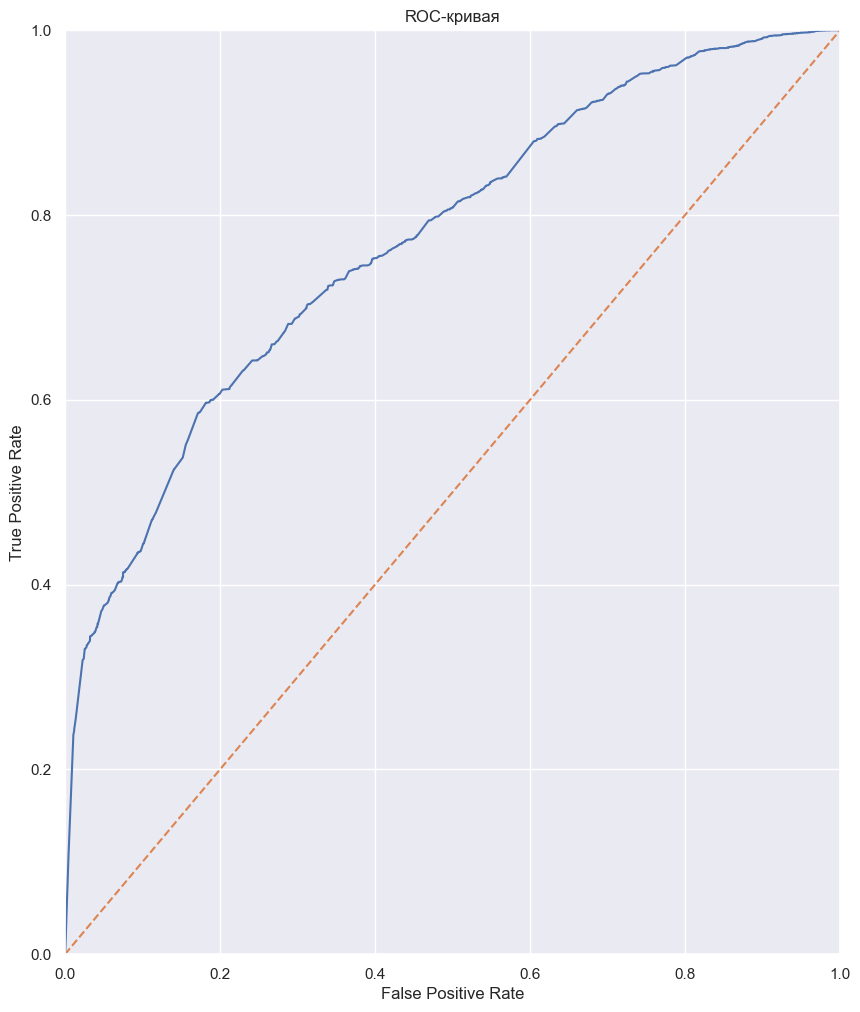

In [105]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities1)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель, которую построили методом Random Forest оказалась лучше случайно-построенной и принесет прибыль заказчику. <br>
Остается посчитать сколько именно денег такая модель может дополнительно извлечь. <br>
Самое время добавить депозит для лиц, к которым модель подозрительно отнесется.

In [106]:
#уже заранее эту переменную мы определяли.
predicted_test

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [107]:
len(predicted_test)

32029

In [108]:
len(df_test)

32029

In [109]:
df_test['preds'] = predicted_test

In [110]:
df_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,preds
0,1,74.0,2017,January,1,1,1,0,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1
1,1,62.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
2,1,62.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1
4,1,172.0,2017,January,1,1,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164.0,2017,August,35,31,2,4,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,0
32408,0,21.0,2017,August,35,30,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,0
32409,0,23.0,2017,August,35,30,2,5,1.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,0
32410,0,34.0,2017,August,35,31,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,0


Учтем предоплату, обновим функцию подсчета прибыли.

In [111]:
'''def row_revenue_update(row):
    room = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['stays_in_week_nights'] + row['stays_in_weekend_nights']
    price = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_night'].median()
    cost = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_service'].median()
    if (row['preds']==1):
        deposit = 0.8*price
        
    else:
        deposit = 0
    if (row['is_canceled'] == 0):
        nights_with_service =  math.floor((total_nights-1)/2)
        if month in ['December', 'January', 'February']:
            revenue = price* total_nights - cost - cost*nights_with_service
        elif month in ['June', 'July', 'August']:
            revenue = 1.4*price* total_nights - cost - cost*nights_with_service
        else:
            revenue = 1.2*price* total_nights - cost - cost*nights_with_service
    else:
        revenue =  deposit - cost
    return revenue
'''

"def row_revenue_update(row):\n    room = row['reserved_room_type']\n    month = row['arrival_date_month']\n    total_nights = row['stays_in_week_nights'] + row['stays_in_weekend_nights']\n    price = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_night'].median()\n    cost = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_service'].median()\n    if (row['preds']==1):\n        deposit = 0.8*price\n        \n    else:\n        deposit = 0\n    if (row['is_canceled'] == 0):\n        nights_with_service =  math.floor((total_nights-1)/2)\n        if month in ['December', 'January', 'February']:\n            revenue = price* total_nights - cost - cost*nights_with_service\n        elif month in ['June', 'July', 'August']:\n            revenue = 1.4*price* total_nights - cost - cost*nights_with_service\n        else:\n            revenue = 1.2*price* total_nights - cost - cost*nights_with_service\n    else:\n        revenue =  deposit - cost\n 

In [112]:
def row_revenue_update(row):
    room = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['stays_in_week_nights'] + row['stays_in_weekend_nights']
    deposit = 0
    price = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_night'].median()
    cost = df_for_revenue[df_for_revenue['reserved_room_type'] == room]['price_for_service'].median()
    if (row['preds']==1):
        if month in ['December', 'January', 'February']:
            deposit  = 0.8 * (price + cost)
        elif month in ['June', 'July', 'August']:
            deposit  = 0.8 * (1.4 * price + cost)
        elif month in ['March','April','May','September','October','November']:
            deposit  = 0.8 * (1.2 * price + cost)  
    if (row['is_canceled'] == 0):
        nights_with_service =  math.floor((total_nights-1)/2)
        if month in ['December', 'January', 'February']:
            revenue = price* total_nights - cost - cost*nights_with_service
        elif month in ['June', 'July', 'August']:
            revenue = 1.4*price* total_nights - cost - cost*nights_with_service
        else:
            revenue = 1.2*price* total_nights - cost - cost*nights_with_service
            
    if (row['is_canceled'] == 1):
        if month in ['December', 'January', 'February']:
            revenue = deposit - price - cost 
        elif month in ['June', 'July', 'August']:
            revenue = deposit - (1.4*price) - cost
        else:
            revenue = deposit - (1.2*price) - cost   
    return revenue

In [113]:
revenue_update = df_test.apply(row_revenue_update, axis=1).sum()
print(revenue_update)

41833788.0


In [114]:
AMOUNT_OF_DEVELOPMENT = 400000

In [115]:
total_revenue_df_test

35209660.0

In [116]:
itog_profit = revenue_update - AMOUNT_OF_DEVELOPMENT - total_revenue_df_test


In [117]:
print('Разработка системы предоплаты при определении моделью ненадежного клиента принесет дополнительно:', itog_profit)

Разработка системы предоплаты при определении моделью ненадежного клиента принесет дополнительно: 6224128.0


## Портрет «ненадёжного» клиента

In [118]:
df_test.query('is_canceled==1 and preds==1').mean()

is_canceled                          1.000000
lead_time                          117.784438
arrival_date_year                 2017.000000
arrival_date_week_number            17.207185
arrival_date_day_of_month           15.784066
stays_in_weekend_nights              0.767126
stays_in_week_nights                 2.216679
adults                               1.022152
children                             0.033879
babies                               0.001862
is_repeated_guest                    0.004468
previous_cancellations               0.007260
previous_bookings_not_canceled       0.022524
booking_changes                      0.029784
days_in_waiting_list                 0.000000
required_car_parking_spaces          0.000000
total_of_special_requests            0.125465
total_nights                         2.983805
preds                                1.000000
dtype: float64

In [119]:
df_test.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'preds'],
      dtype='object')

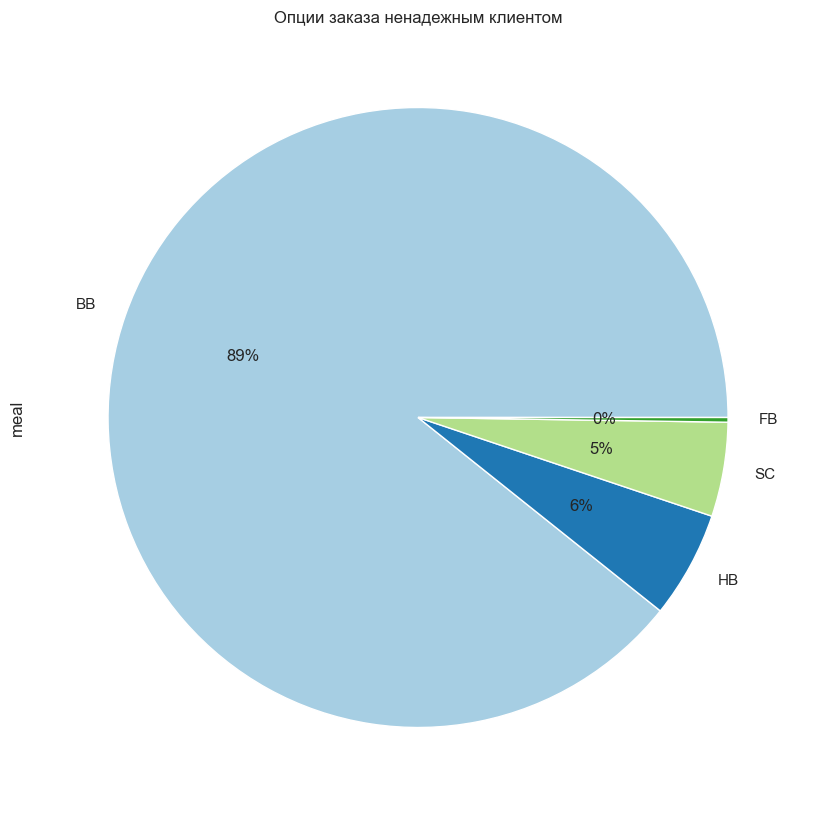

In [120]:
df_test.query('is_canceled==1 and preds==1')['meal'].value_counts(normalize=True).plot.pie(
    autopct='%1.0f%%', colors=colors).set_title('Опции заказа ненадежным клиентом')
plt.show()

Ненадежный клиент часто берет завтрак в заказ. 

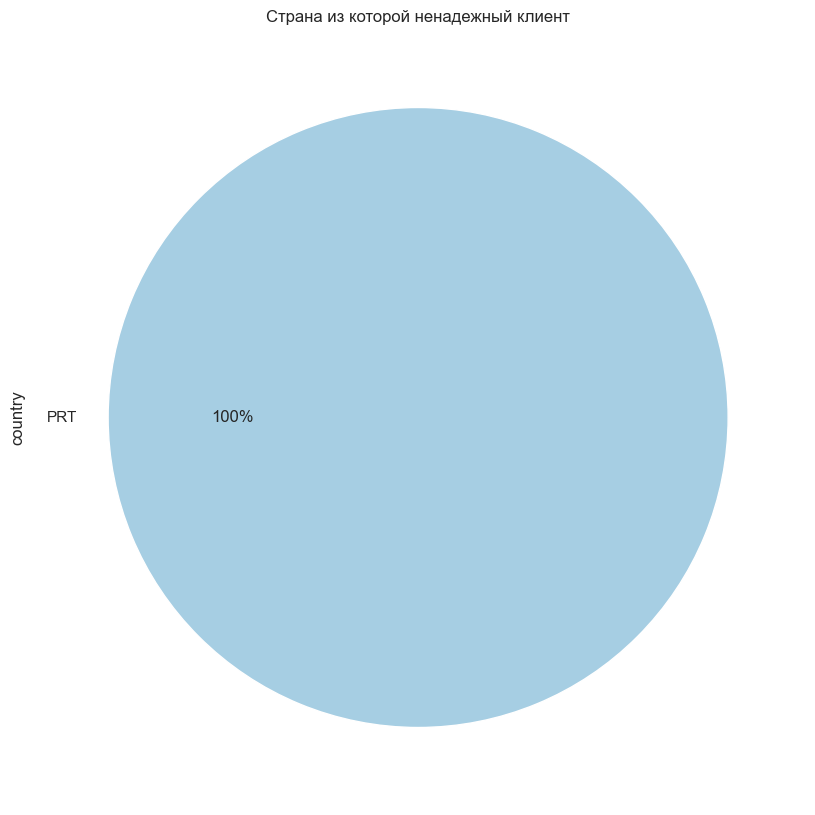

In [121]:
df_test.query('is_canceled==1 and preds==1')['country'][:4].value_counts(normalize=True).sort_values(
    ascending = False)[:10].plot.pie(autopct='%1.0f%%', colors=colors).set_title('Страна из которой ненадежный клиент')
plt.show()

На графике топ10 стран, откуда вполне вероятно прибудет ненадежный клиент. 

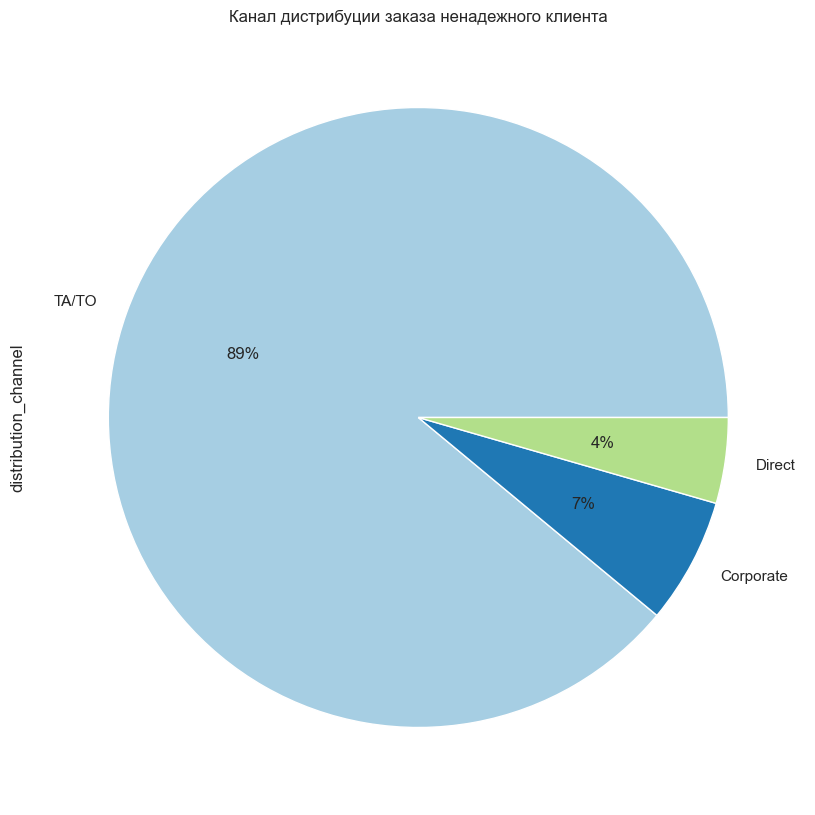

In [122]:
df_test.query('is_canceled==1 and preds==1')['distribution_channel'].value_counts(normalize=True)[:3].plot.pie(
    autopct='%1.0f%%', colors=colors).set_title('Канал дистрибуции заказа ненадежного клиента')
plt.show()

Канал дистрибуции заказа ненадежного канала чаще всего: TA/TO

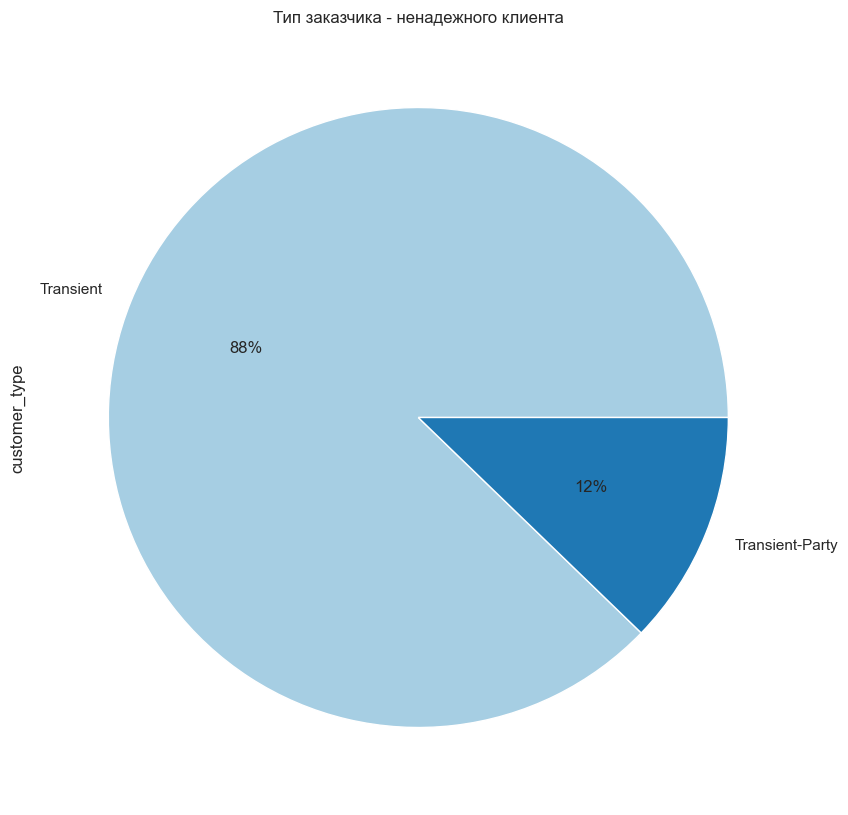

In [123]:
df_test.query('is_canceled==1 and preds==1')['customer_type'].value_counts(normalize=True)[:2].plot.pie(
    autopct='%1.0f%%', colors=colors).set_title('Тип заказчика - ненадежного клиента')
plt.show()

Чаще всего Тип заказчика, который оказывается ненадежным клиентом - Transient. Чуть реже Transient-Party. Остальные типы около нуля.

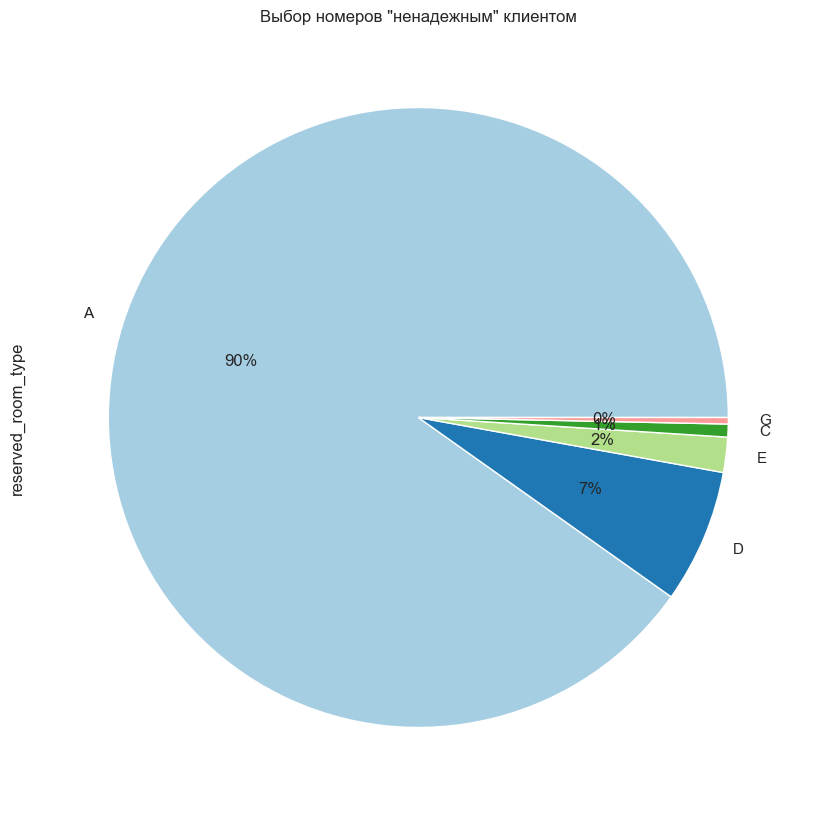

In [124]:
df_test.query('is_canceled==1 and preds==1')['reserved_room_type'].value_counts(normalize=True)[:5].plot.pie(
    autopct='%1.0f%%', colors=colors).set_title('Выбор номеров "ненадежным" клиентом')
plt.show()

Чаще всего "ненадежный" клиент выбирает самый экономный номер, тип A. <br>
Чуть реже тип номера D

**Ненадежный клиент**, кто же он: <br>
- Бронирует в среднем за 122 дня.
- Два взрослых.
- Без детей.
- Бронирует номер впервые.
- Не отменял ранее заказ.
- Не изменяет заказ.
- Не заказывает парковочное место.
- Количество специальных отметок равно нулю.
- Заказывает завтрак.
- Из Португалии. 
- Канал дистрибуции заказа  TA/TO
- Тип заказчика - Transient
- Заказывает номер типа A, реже D

## Вывод
Пытаясь спрогнозировать отмену бронирования номеров в отеле, провели исследование, каковы же его итоги:
- Была выполнена предобработка данных, для обучения модели удалили ненужные столбцы, которые не сыграют роли.
- При анализе данных заметили некоторое кол-во выбросов, почистили. 
- Просмотрели визуально распределение столбцов.
- Самую большую зависимость на целевой признак определяли столбцы "total_of_special_requests", 'required_car_parking_spaces', 'previous_cancellations', 'booking_changes' и 'lead_time'
- Далее мы написали функцию, которая подсчитала прибыль. В итоге, сумма прибыли за 2017 год:35209660
- Приступили к обучению модели. Опытным тестом определили, что лучшие результаты имеет модель RandomForest с гиперпараметрами:depth: 3 и n_estimators:20 c f1 score 0.6692505389711126
- f1 на тест. выборке: 0.5480793756057747 и AUC-ROC на тест.выборке: 0.7703842618368981
- Когда же модель была протестирована на тест.выборке, мы изменили функцию с учетом 80% оплаты брони для ненадежного клиента. 

Как итог, разработка системы предоплаты при определении моделью ненадежного клиента принесет дополнительно:6224128

Определенно, данная модель поможет заработать больше денег. И полностью окупит себя за первый же год работы.